# Master Shear-Wave Splitting Workflow for Axial Seamount

This notebook provides a complete, clean workflow from raw earthquake catalog and waveform data to shear-wave splitting analysis results. The workflow follows proper sequencing and includes all necessary quality control measures.

## Workflow Overview

1. **Data Loading & Initial Setup** - Load earthquake catalog and station metadata
2. **Extended Time Window Creation** - Create proper time windows for waveform retrieval
3. **Waveform Data Retrieval** - Download seismic data with extended windows
4. **Quality Control Filters** - P-wave rectilinearity, SNR, and incidence angle filtering
5. **Geometric Calculations** - Back-azimuth and distance calculations
6. **Shear-Wave Splitting Analysis** - Dynamic parameter estimation and SWSPy analysis
7. **Results Processing & Visualization** - Compile and visualize splitting parameters

## Key Improvements
- Extended catalog creation moved to proper early position
- Updated P-wave polarization analysis for true incidence angles
- Integrated SNR calculations with proper S-wave timing
- Clean separation of quality control steps

## 1. Import Requirements

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn import Client
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import pykonal


# Import project modules
from axial_velocity_model import AxialVelocityModel
from obs_array import OBSArray
from earthquake_location import RayTracer
from anisotropy_optimizer import AnisotropyOptimizer
import visualization as viz

# Add local swspy directory to path (before other imports)
swspy_local_path = os.path.abspath('../swspy')
if swspy_local_path not in sys.path:
    sys.path.insert(0, swspy_local_path)

# Import swspy from local directory
import swspy

# Add scripts directory to path for custom modules
sys.path.append('.')
from seismic_geometry import (calculate_back_azimuth, calculate_epicentral_distance_km)
from get_all_traces import get_station_traces
from splitting_functions import *

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully")
print(f"ObsPy version: {obspy.__version__}")
print(f"SWSPy available: {'Yes' if 'swspy' in sys.modules else 'No'}")
print(f"SWSPy location: {swspy.__file__}")

mtspec not available, using ObsPy PPSD method
Libraries imported successfully
ObsPy version: 1.4.2
SWSPy available: Yes
SWSPy location: /Users/mhemmett/Seismology/Axial_Splitting/swspy/swspy/__init__.py


## 2. Raw Data Organization

First, we need to process the raw phase pick data to create a structured catalog where each row represents one event at a single station with both P- and S-wave arrival times.

In [2]:
# Parse raw phase pick data and create organized catalog

# Load and parse the raw phase pick data
print("Loading raw phase pick data from Axial Seamount...")

# Parse the phase file
phase_file = '../data/ax.hinv.pha.shots_erup'
events_df, phases_df = parse_phase_file(phase_file)

print(f"\nParsed {len(events_df)} events and {len(phases_df)} phase picks")
print(f"Date range: {events_df['year'].min()}-{events_df['year'].max()}")

# Display sample of parsed data
print(f"\nSample events:")
display(events_df.head())

print(f"\nSample phases:")
display(phases_df.head())

# Create organized catalog structure
raw_catalog = create_organized_catalog(events_df, phases_df)


Loading raw phase pick data from Axial Seamount...
Parsing phase file: ../data/ax.hinv.pha.shots_erup
Processing 2551850 lines...

Parsed 273829 events and 2278021 phase picks
Date range: 2014-2021

Sample events:


event_id  year  month  day  hour  minute  second              datetime_str  \
0   1000000  2014     11    4    20      39   59.02  2014-11-04T20:39:59.020Z   
1   1000001  2014     11    4    20      42   12.47  2014-11-04T20:42:12.470Z   
2   1000002  2014     11    4    20      46    1.97  2014-11-04T20:46:01.970Z   
3   1000003  2014     11    4    20      46   35.13  2014-11-04T20:46:35.130Z   
4   1000004  2014     11    4    20      47    7.00  2014-11-04T20:47:07.000Z   

       lat       lon  depth  magnitude  
0  45.9242 -130.0807   1.10        0.0  
1  45.9398 -130.0170   0.42        0.0  
2  45.9307 -130.0115   0.22        0.0  
3  45.9347 -130.0153   0.54        0.0  
4  45.9303 -130.0117   0.07        0.0


Sample phases:


event_id            event_datetime  event_lat  event_lon  event_depth  \
0   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
1   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
2   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
3   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
4   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   

   event_magnitude  station  arrival_time  weight phase_type quality  
0              0.0  OOAXAS2          1.42     NaN          P      EH  
1              0.0  OOAXAS2          1.93     NaN          S      EH  
2              0.0  OOAXEC3          1.29    -0.5          P      EH  
3              0.0  OOAXEC3          2.46    -0.2          S      EH  
4              0.0  OOAXEC2          0.68     0.5          P      HH

Creating organized catalog with events × stations structure...
Events: 273829, Stations: 7
Stations in network: ['OOAXAS1', 'OOAXAS2', 'OOAXCC1', 'OOAXEC1', 'OOAXEC2', 'OOAXEC3', 'OOAXID1']
Total event-station pairs: 1916803
Pairs with both P and S picks: 982168


TypeError: object of type 'NoneType' has no len()

In [3]:
print(f"\nOrganized catalog created with {len(raw_catalog)} event-station pairs")
print(f"Events: {raw_catalog['id'].nunique()}, Stations: {raw_catalog['station'].nunique()}")

# Display sample of organized catalog
print(f"\nSample of organized catalog:")
display(raw_catalog.head())

TypeError: object of type 'NoneType' has no len()

In [8]:
# Load earthquake catalog
catalog = pd.read_csv('2018_eq_catalog.csv')

# Edit catalog to only include data from June - Dec 2015
# Also remove unnecessary columns: total_picks, p_weight, p_quality, s_weight, s_quality, and index
start_date = UTCDateTime("2015-06-01T00:00:00")
end_date = UTCDateTime("2015-12-31T23:59:59")
edited_catalog = catalog[(catalog['datetime'] >= start_date) & (catalog['datetime'] <= end_date)].copy()
#edited_catalog = edited_catalog.drop(columns=['total_picks', 'p_weight', 
#                                              'p_quality', 's_weight', 's_quality'])

edited_catalog.reset_index(drop=True, inplace=True)

In [12]:
# Use the organized catalog created from raw phase picks
print("Using organized catalog created from raw phase pick data...")

# Set catalog as our working dataset
catalog = edited_catalog.copy()

print(f"Working catalog has {len(catalog)} event-station pairs")
print(f"Date range: {catalog['datetime'].min()} to {catalog['datetime'].max()}")

# Display basic catalog info
print("\nCatalog columns:", catalog.columns.tolist())
print("\nFirst few events:")
display(catalog.head())


Using organized catalog created from raw phase pick data...
Working catalog has 12635 event-station pairs
Date range: 2015-06-01T00:35:49.610Z to 2015-12-31T21:35:41.950Z

Catalog columns: ['Unnamed: 0', 'id', 'year', 'datetime', 'lat', 'lon', 'dep', 'mag', 'station', 'p_arrival_time', 's_arrival_time']

First few events:


Unnamed: 0       id  year                  datetime      lat       lon  \
0      536619  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
1      536620  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
2      536621  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
3      536622  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
4      536623  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   

    dep  mag  station  p_arrival_time  s_arrival_time  
0  0.59  0.0  OOAXEC3            0.42            0.93  
1  0.59  0.0  OOAXEC2            0.40            0.97  
2  0.59  0.0  OOAXAS1            0.56            1.19  
3  0.59  0.0  OOAXCC1            0.62            1.37  
4  0.59  0.0  OOAXEC1            0.34            0.75

In [13]:
# Save formatted catalog to csv
catalog.to_csv('2015_jun_dec_eq_catalog.csv')

In [2]:
# Load earthquake catalog
catalog = pd.read_csv('2015_jun_dec_eq_catalog.csv')

# Load station information
stations_file = '../data/axial_seamount_stations.csv'
stations_df = pd.read_csv(stations_file)

print(f"Stations in catalog: {catalog['station'].value_counts()}")

Stations in catalog: station
OOAXEC3    2653
OOAXEC1    2280
OOAXCC1    2050
OOAXEC2    1944
OOAXAS1    1829
OOAXAS2    1181
OOAXID1     698
Name: count, dtype: int64


## 3. Extended Time Window Creation

This step creates extended time windows for waveform retrieval. This is critical for proper analysis and must happen early in the workflow, before any quality control that depends on waveform data.

In [3]:
# Create extended time windows for proper waveform analysis
print("Creating extended time windows for waveform retrieval...")

# Apply extended windowing
extended_catalog = create_extended_catalog(catalog, pre_event_time=4.0, post_event_time=15.0)

print(f"Extended catalog created with {len(extended_catalog)} events")
print(f"Time windows: {extended_catalog['total_duration'].iloc[0]} seconds total")
print(f"Pre-event: {extended_catalog['pre_event_sec'].iloc[0]}s, Post-event: {extended_catalog['post_event_sec'].iloc[0]}s")

# Display sample of extended timing
print("\nSample timing windows:")
sample_cols = ['id', 'datetime', 'starttime', 'endtime', 'total_duration']
display(extended_catalog[sample_cols].head())

Creating extended time windows for waveform retrieval...
Extended catalog created with 12635 events
Time windows: 19.0 seconds total
Pre-event: 4.0s, Post-event: 15.0s

Sample timing windows:


id                  datetime                    starttime  \
0  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
1  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
2  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
3  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
4  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   

                       endtime  total_duration  
0  2015-06-01T00:36:04.610000Z            19.0  
1  2015-06-01T00:36:04.610000Z            19.0  
2  2015-06-01T00:36:04.610000Z            19.0  
3  2015-06-01T00:36:04.610000Z            19.0  
4  2015-06-01T00:36:04.610000Z            19.0

In [4]:

# Filter for stations AXAS1, AXCC1, AXEC2, and AXID1
filtered_catalog = extended_catalog[
    (extended_catalog['station'] == 'OOAXAS1') | 
    (extended_catalog['station'] == 'OOAXCC1') | 
    (extended_catalog['station'] == 'OOAXEC2') | 
    (extended_catalog['station'] == 'OOAXID1') ].copy()

print(f"Filtered catalog has {len(filtered_catalog)} events for stations AXAS1, AXCC1, AXEC2, and AXID1")

# Keep the first 100 events
print("Keeping the first 100 events for testing...")
test_catalog = filtered_catalog.head(100).copy()

# Remove leading 'OO' from station names
test_catalog['station'] = test_catalog['station'].str.replace('OO', '', regex=False)

Filtered catalog has 6521 events for stations AXAS1, AXCC1, AXEC2, and AXID1
Keeping the first 100 events for testing...


## 4. Waveform Data Retrieval

This section retrieves seismic waveform data using the extended time windows. We'll load the existing trace data and organize it for processing.

In [5]:
# Retrieve waveforms for all events in the test catalog using get_all_traces function
print("Retrieving waveforms for all events in the test catalog...")
waveforms = get_station_traces(test_catalog, 'first_event', 'starttime', 'endtime', 'station')

Retrieving waveforms for all events in the test catalog...
Retrieved data for AXEC2 HHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHZ from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHZ from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved d

In [6]:
# Associate waveforms with events in the catalog
print("Organizing waveforms by events...")
waveform_dict = organize_stream_by_events(waveforms, test_catalog)

Organizing waveforms by events...
Organizing stream data for 100 events...
  Event 1: Found 3 traces for AXEC2 at 2015-06-01T00:35:49.610000Z
  Event 2: Found 3 traces for AXAS1 at 2015-06-01T00:35:49.610000Z
  Event 3: Found 3 traces for AXCC1 at 2015-06-01T00:35:49.610000Z
  Event 4: Found 3 traces for AXEC2 at 2015-06-01T00:44:50.590000Z
  Event 5: Found 3 traces for AXCC1 at 2015-06-01T00:44:50.590000Z
  Event 6: Found 3 traces for AXCC1 at 2015-06-01T04:27:35.690000Z
  Event 7: Found 3 traces for AXAS1 at 2015-06-01T04:34:14.540000Z
  Event 8: Found 3 traces for AXCC1 at 2015-06-01T04:34:14.540000Z
  Event 9: Found 3 traces for AXAS1 at 2015-06-01T04:52:10.190000Z
  Event 10: Found 3 traces for AXCC1 at 2015-06-01T04:52:10.190000Z
  Event 11: Found 3 traces for AXCC1 at 2015-06-01T05:08:11.970000Z
  Event 12: Found 3 traces for AXEC2 at 2015-06-01T07:36:43.960000Z
  Event 13: Found 3 traces for AXAS1 at 2015-06-01T08:02:26.880000Z
  Event 14: Found 3 traces for AXEC2 at 2015-06-01

In [7]:
# Replace catalog id with index
test_catalog['id'] = test_catalog.index

In [8]:
# Organize waveforms by event ID
print("Organizing waveforms by event ID...")
organized_waveforms = organize_waveform_data(waveform_dict, test_catalog)

Organizing waveforms by event ID...


## 5. Quality Control Pipeline

This section implements comprehensive quality control measures including P-wave rectilinearity analysis, signal-to-noise ratio calculations, and incidence angle filtering.

In [9]:
# Define quality control thresholds
QC_THRESHOLDS = {
    'min_snr': 2.0,           # Minimum S-wave signal-to-noise ratio
    'min_rectilinearity': 0.7, # Minimum P-wave rectilinearity
    'max_incidence': 30.0,     # Maximum incidence angle (degrees)
    'min_magnitude': 0.0,      # Minimum event magnitude
}

print("Quality control functions loaded successfully")
print(f"QC Thresholds: {QC_THRESHOLDS}")

Quality control functions loaded successfully
QC Thresholds: {'min_snr': 2.0, 'min_rectilinearity': 0.7, 'max_incidence': 30.0, 'min_magnitude': 0.0}


In [10]:
# Calculate quality control metrics for organized waveforms
print("Calculating quality control metrics for organized waveforms...")

# 1. Calculate S-wave SNR
organized_waveforms = calculate_snr_for_organized_waveforms(organized_waveforms)

# 2. Calculate geographic back-azimuth, for coordinate rotation later
organized_waveforms = calculate_back_azimuth_for_organized_waveforms(organized_waveforms, stations_df)

# 3. Calculate P-wave rectilinearity and incidence angle
organized_waveforms = calculate_p_wave_metrics_for_organized_waveforms(organized_waveforms)

Calculating quality control metrics for organized waveforms...
Calculating SNR for 100 events in organized_waveforms...

Processing event 1...
  Found 3 traces for this event

  Calculating SNR for E component:
  S-pick time: 2015-06-01T00:35:50.580000Z
  S-P delay: 0.57s
  Found E trace: 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
  Noise window: 2015-06-01T00:35:50.295000Z to 2015-06-01T00:35:50.580000Z (0.28s)
  Signal window: 2015-06-01T00:35:50.580000Z to 2015-06-01T00:35:50.780000Z (0.20s)
  Noise data points: 58
  Signal data points: 41
  Noise RMS: 20.832995
  Signal RMS: 31.270085
  SNR: 1.50

  Calculating SNR for N component:
  S-pick time: 2015-06-01T00:35:50.580000Z
  S-P delay: 0.57s
  Found N trace: 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
  Noise window: 2015-06-01T00:35:50.295000Z to 2015-06-01T00:35:50.580000Z (0.28s)
  Signal window: 2015-06-01T00:35:50.580000Z to 2015-06-01T00:35:50.780000Z (0.20s)
  Noise data points: 58
  Signal da

In [11]:
# Use quality control metrics to filter waveforms
print("Applying quality control filters to waveforms...")
passing_waveforms = apply_quality_control(organized_waveforms, QC_THRESHOLDS)

Applying quality control filters to waveforms...

Applying Quality Control Filters
Initial events: 100

QC Thresholds:
  Minimum SNR: 2.0
  Minimum Rectilinearity: 0.7
  Maximum Incidence: 30.0°
  Minimum Magnitude: 0.0

Checking Individual Events
✗ Event 1: FAIL - SNR too low (1.63 < 2.0)
✗ Event 2: FAIL - SNR too low (1.73 < 2.0), Rectilinearity too low (0.663 < 0.7), Incidence too high (86.3° > 30.0°)
✗ Event 3: FAIL - SNR too low (1.87 < 2.0), Incidence too high (33.2° > 30.0°)
✗ Event 6: FAIL - Incidence too high (77.3° > 30.0°)
✗ Event 7: FAIL - SNR too low (1.91 < 2.0), Incidence too high (43.8° > 30.0°)
✗ Event 12: FAIL - Incidence too high (84.9° > 30.0°)
✗ Event 15: FAIL - SNR too low (1.61 < 2.0), Rectilinearity too low (0.646 < 0.7), Incidence too high (56.6° > 30.0°)
✗ Event 16: FAIL - Incidence too high (72.0° > 30.0°)
✗ Event 18: FAIL - Rectilinearity too low (0.476 < 0.7), Incidence too high (61.0° > 30.0°)
✗ Event 19: FAIL - Incidence too high (33.6° > 30.0°)
✓ Event 2

Plotting waveforms for station AXCC1


TypeError: 'NoneType' object cannot be interpreted as an integer

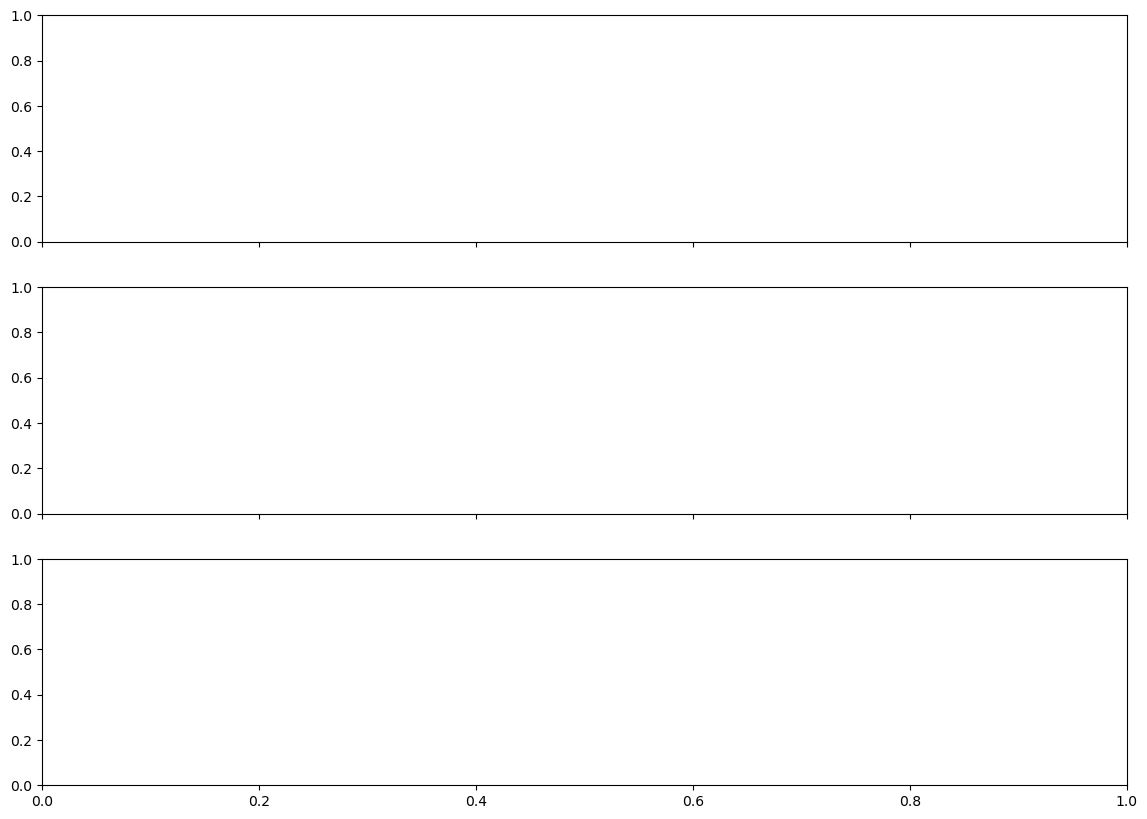

In [12]:
# Plot waveforms for organized_waveforms[3]
event_data = organized_waveforms[3]

# Check if waveforms were successfully retrieved
if event_data.get('traces') is None or len(event_data['traces']) == 0:
    print(f"⚠ No waveforms available for event {event_data.get('id')}, skipping...")
else:
    st = event_data['traces'].copy()
    print(f"Plotting waveforms for station {event_data.get('station')}")
    
    # Sort traces by channel (Z, N, E order)
    st = st.sort(['channel'])
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Get P and S times relative to trace start
    trace_start = st[0].stats.starttime
    p_time = UTCDateTime(event_data.get('p_arrival'))
    s_time = UTCDateTime(event_data.get('s_arrival'))
    p_time_rel = float(p_time - trace_start)
    s_time_rel = float(s_time - trace_start)
    
    # Plot each component
    for i, tr in enumerate(st):
        ax = axes[i]
        
        # Time array (relative to start)
        time = np.arange(len(tr.data)) / tr.stats.sampling_rate

        # Filter and taper
        tr.filter("bandpass", freqmin=5, freqmax=40)
        tr.taper(type="hann", max_percentage=0.05)
        
        # Plot waveform
        ax.plot(time, tr.data, 'k', linewidth=0.8)
        ax.set_ylabel(f"{tr.stats.channel}\nAmplitude", fontweight='bold', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Normalize to show all traces clearly
        ylim = np.max(np.abs(tr.data))
        ax.set_ylim([-ylim * 1.1, ylim * 1.1])
        ax.set_xlim([4, 15])
        
        # Add S-wave window shading first (so it's behind markers)
        ax.axvspan(s_time_rel - 0.5, s_time_rel + 1.5, 
                  alpha=0.15, color='red', zorder=0)
        
        # Add phase markers
        ax.axvline(p_time_rel, color='blue', linestyle='--', alpha=0.8, 
                  linewidth=2, label='P-wave', zorder=5)
        ax.axvline(s_time_rel, color='red', linestyle='--', alpha=0.8, 
                  linewidth=2, label='S-wave', zorder=5)
        
        if i == 0:
            ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axes[-1].set_xlabel('Time (s)', fontweight='bold', fontsize=11)
    
    # Create title
    depth_str = f"{event_data.get('depth', 'unknown'):.2f} km" if event_data.get('depth') is not None else "unknown"
    title = (f"Three-Component Seismogram (Filtered 5-40 Hz) - Station {event_data.get('station')}\n"
            f"Event Time: {event_data.get('datetime')}, Depth: {depth_str}")
    
    fig.suptitle(title, fontsize=12, fontweight='bold', y=0.98)
    
    # Add text box with metrics if available
    info_lines = []
    if 'rectilinearity' in event_data:
        info_lines.append(f"Rectilinearity = {event_data['rectilinearity']:.3f}")
    if 'snr' in event_data:
        info_lines.append(f"SNR = {event_data['snr']:.2f}")
    if 'incidence_angle' in event_data:
        info_lines.append(f"Incidence angle = {event_data['incidence_angle']:.1f}°")
    
    if info_lines:
        info_text = "Quality Metrics:\n  " + "\n  ".join(info_lines)
        axes[0].text(0.98, 0.97, info_text, transform=axes[0].transAxes,
                    fontsize=9, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, 
                             edgecolor='black', linewidth=1.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Station: {event_data.get('station')}, Time: {event_data.get('datetime')}")
    print(f"  P-arrival at: {p_time_rel:.2f} s")
    print(f"  S-arrival at: {s_time_rel:.2f} s")
    print(f"{'='*80}\n")

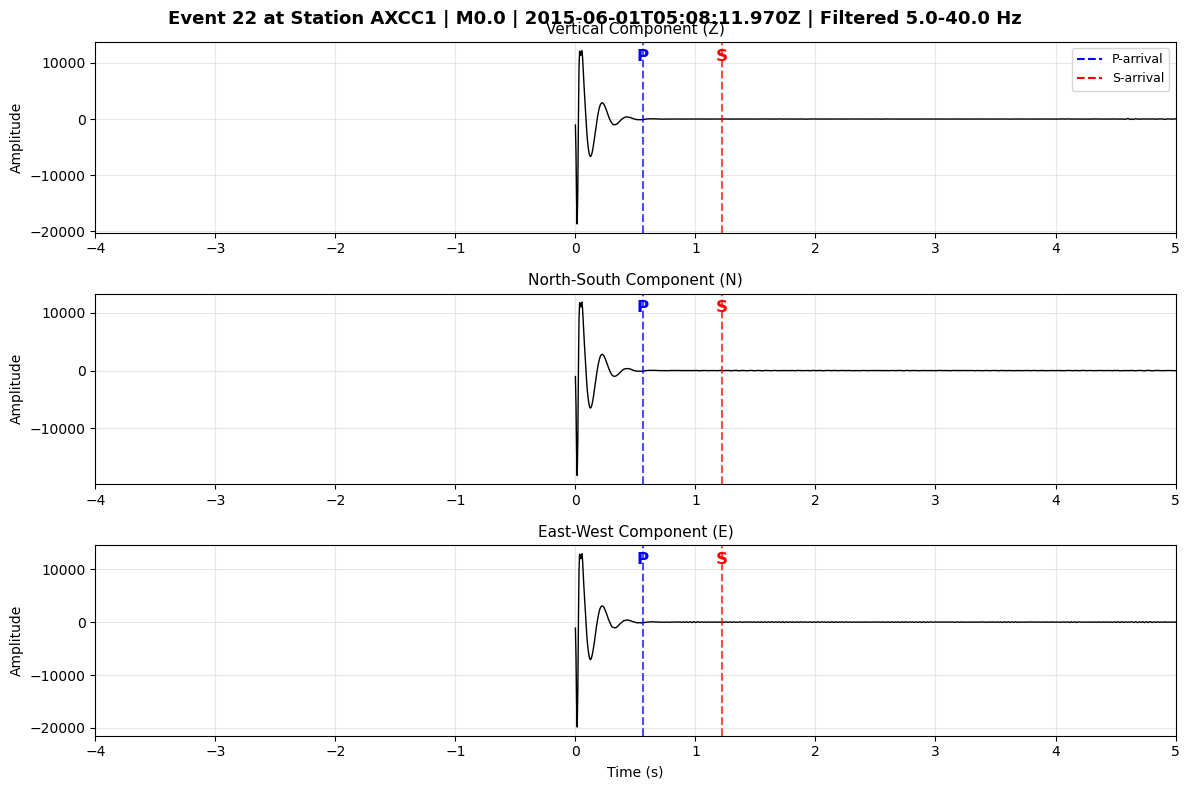

In [14]:
plot_three_component_seismogram(passing_waveforms[22], 22, time_window = (-4, 5))
plt.show()

## 6. Shear-Wave Splitting Analysis

This section implements the core shear-wave splitting analysis using SWSPy with dynamic parameter estimation and comprehensive quality assessment.

Performing shear-wave splitting analysis using SWSPy...

Performing Shear-Wave Splitting Analysis
Processing 10 QC-filtered events...

────────────────────────────────────────────────────────────
Event 22
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 112.56°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 3.78
  Rectilinearity: 0.967
  Incidence: 22.0°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz
  Creating SWSPy splitting object...
    Station: AXCC1
    Back-azimuth: 112.56°
  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  Extracting results from sws_result_df...
  Generating diagnostic plots...


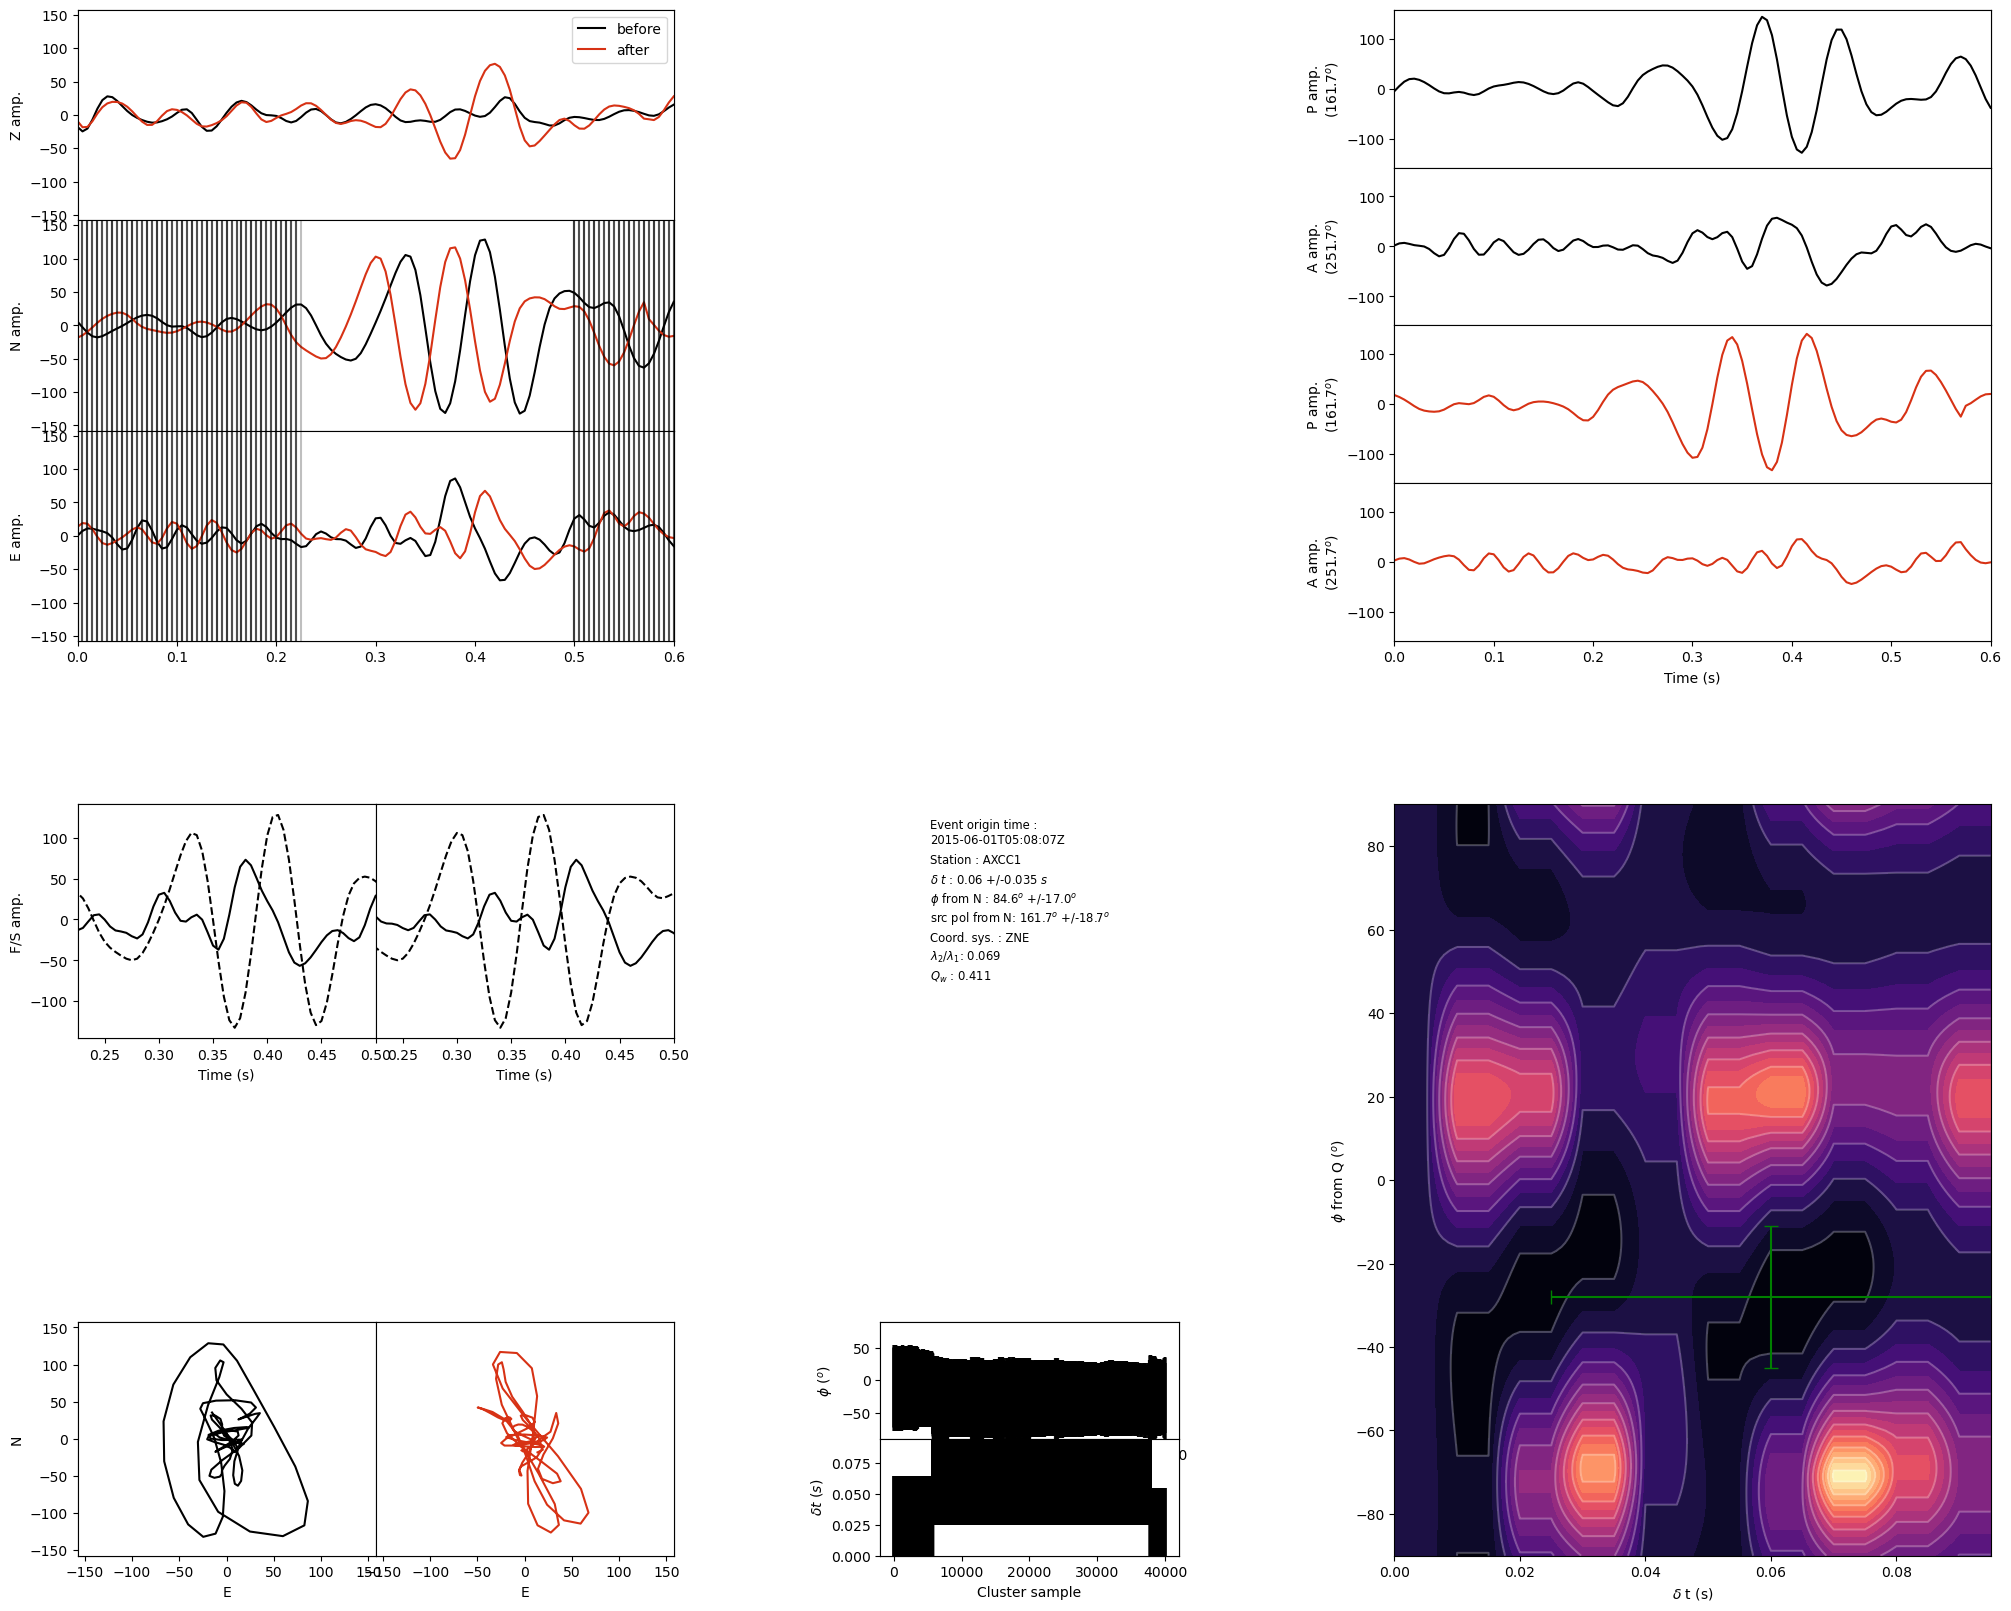

  ✓ Splitting analysis complete!
    Fast axis (φ): 84.6°
    Delay time (δt): 0.060s
  ✓ SUCCESS!
    Fast axis (φ): 84.6°
    Delay time (δt): 0.060s
    φ error: ±17.0°
    δt error: ±0.035s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 41
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 156.11°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 3.02
  Rectilinearity: 0.800
  Incidence: 22.8°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

  ✓ Splitting analysis complete!
    Fast axis (φ): 2.1°
    Delay time (δt): 0.020s
  ✓ SUCCESS!
    Fast axis (φ): 2.1°
    Delay time (δt): 0.020s
    φ error: ±20.5°
    δt error: ±0.010s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 45
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 70.63°
  Station: AXAS1
  Magnitude: 0.0
  SNR: 2.38
  Rectilinearity: 0.929
  Incidence: 18.1°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz

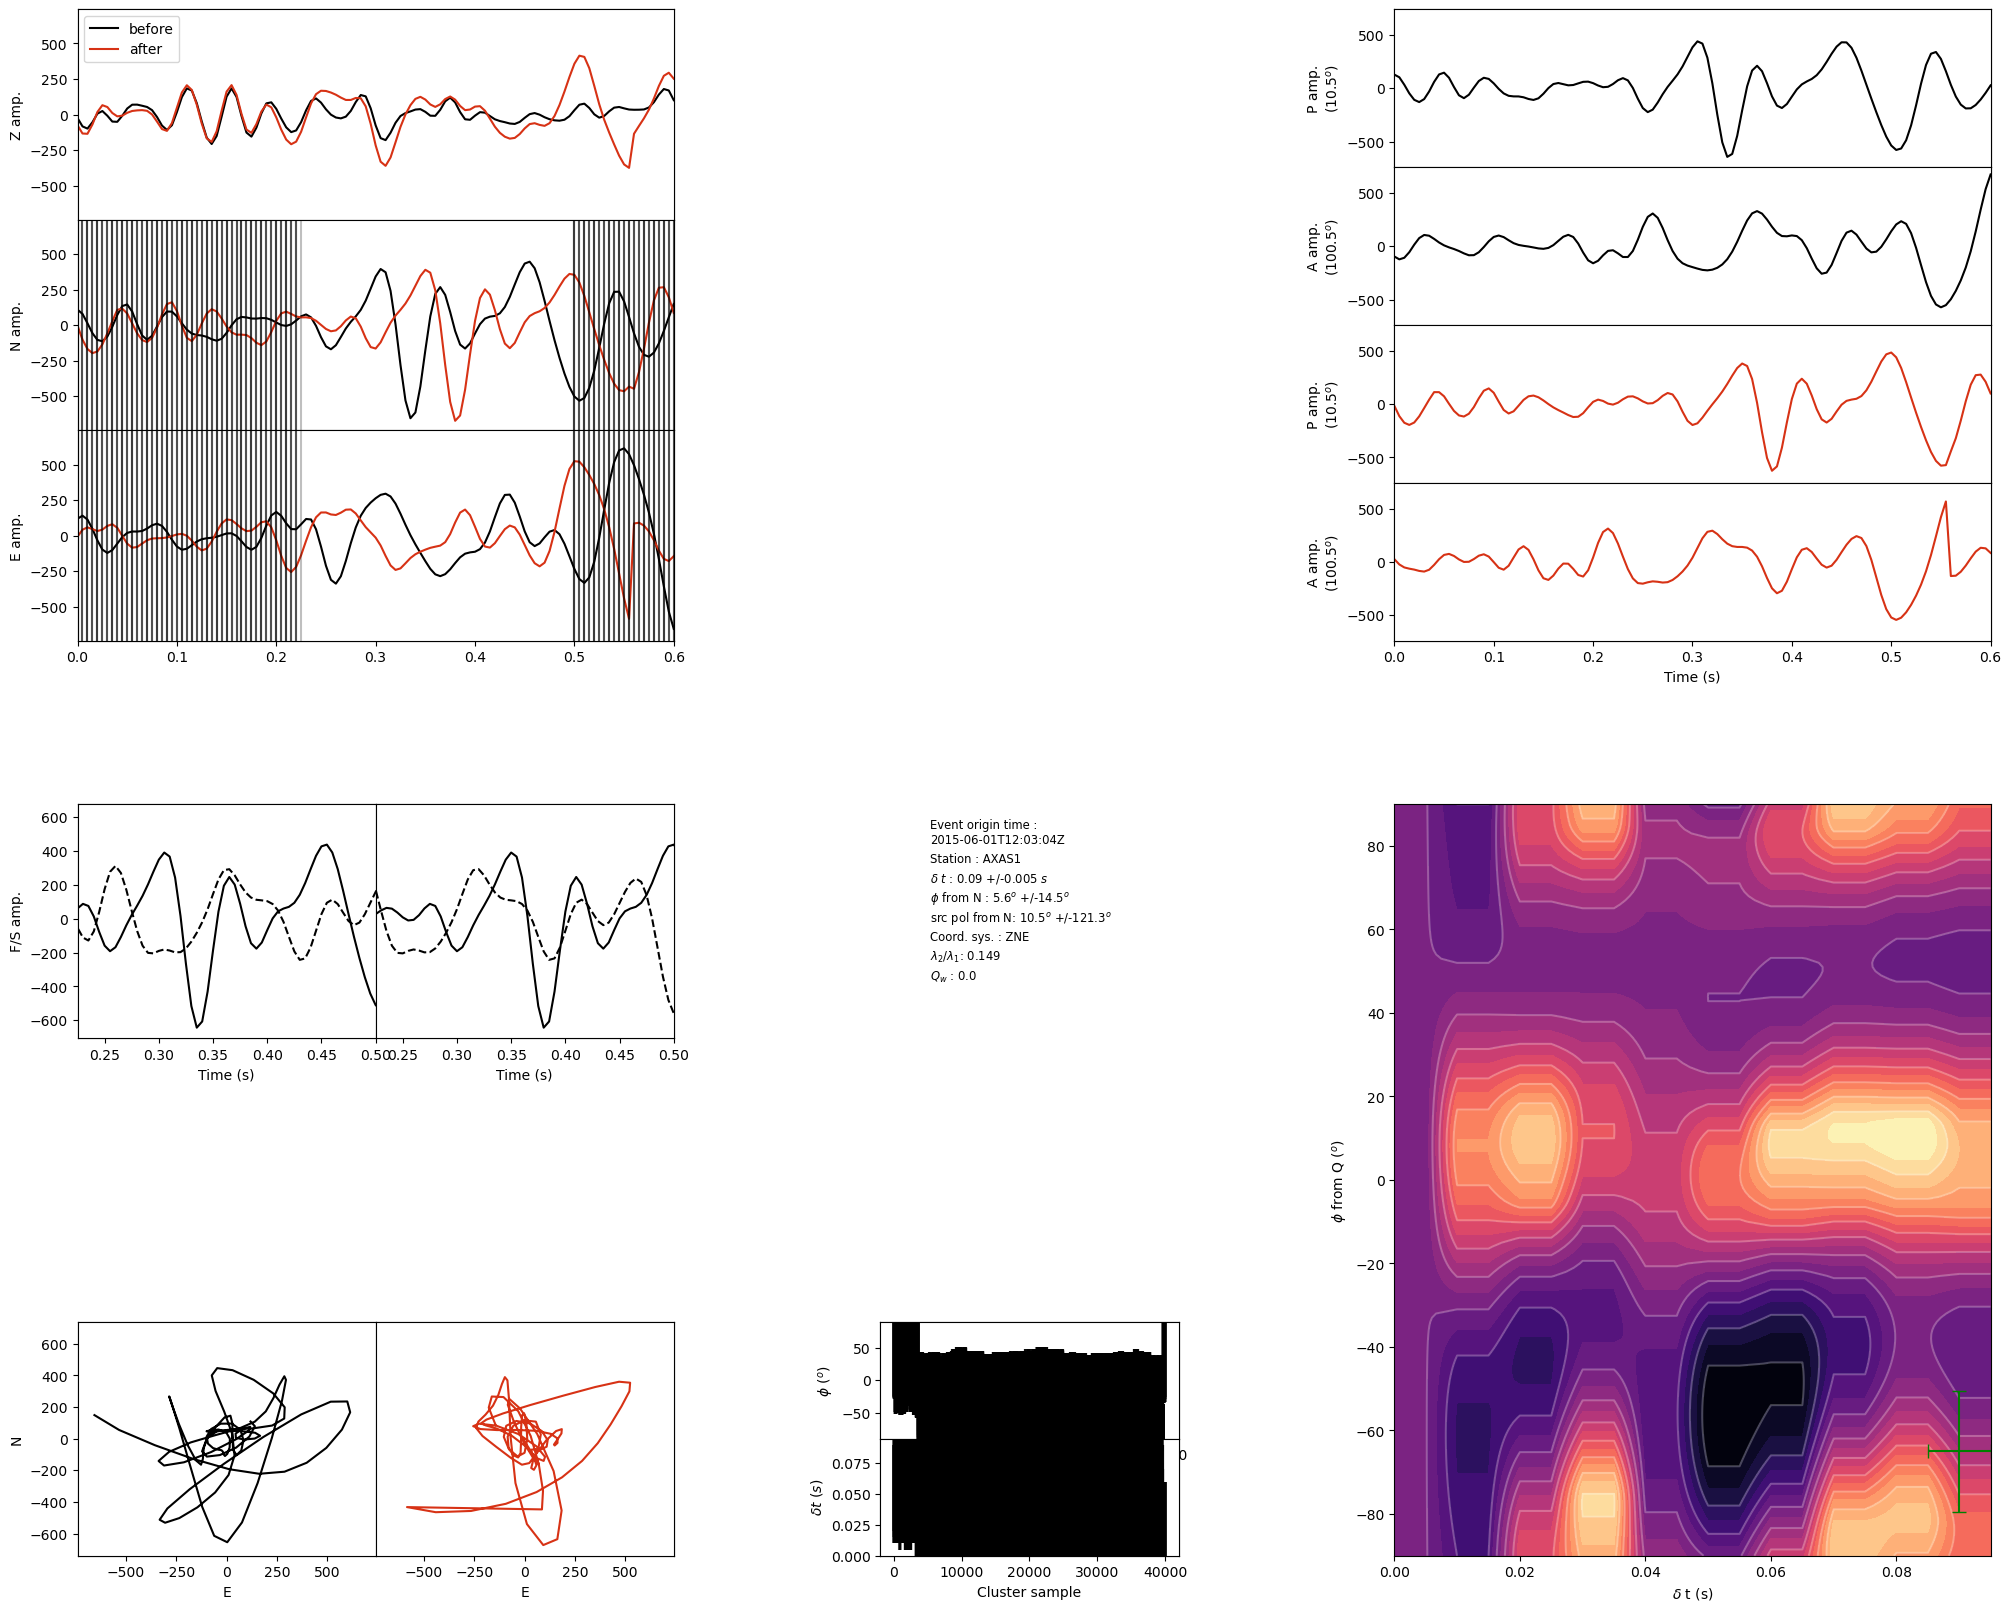

  ✓ Splitting analysis complete!
    Fast axis (φ): 5.6°
    Delay time (δt): 0.090s
  ✓ SUCCESS!
    Fast axis (φ): 5.6°
    Delay time (δt): 0.090s
    φ error: ±14.5°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 52
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 94.98°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 4.94
  Rectilinearity: 0.982
  Incidence: 11.8°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz

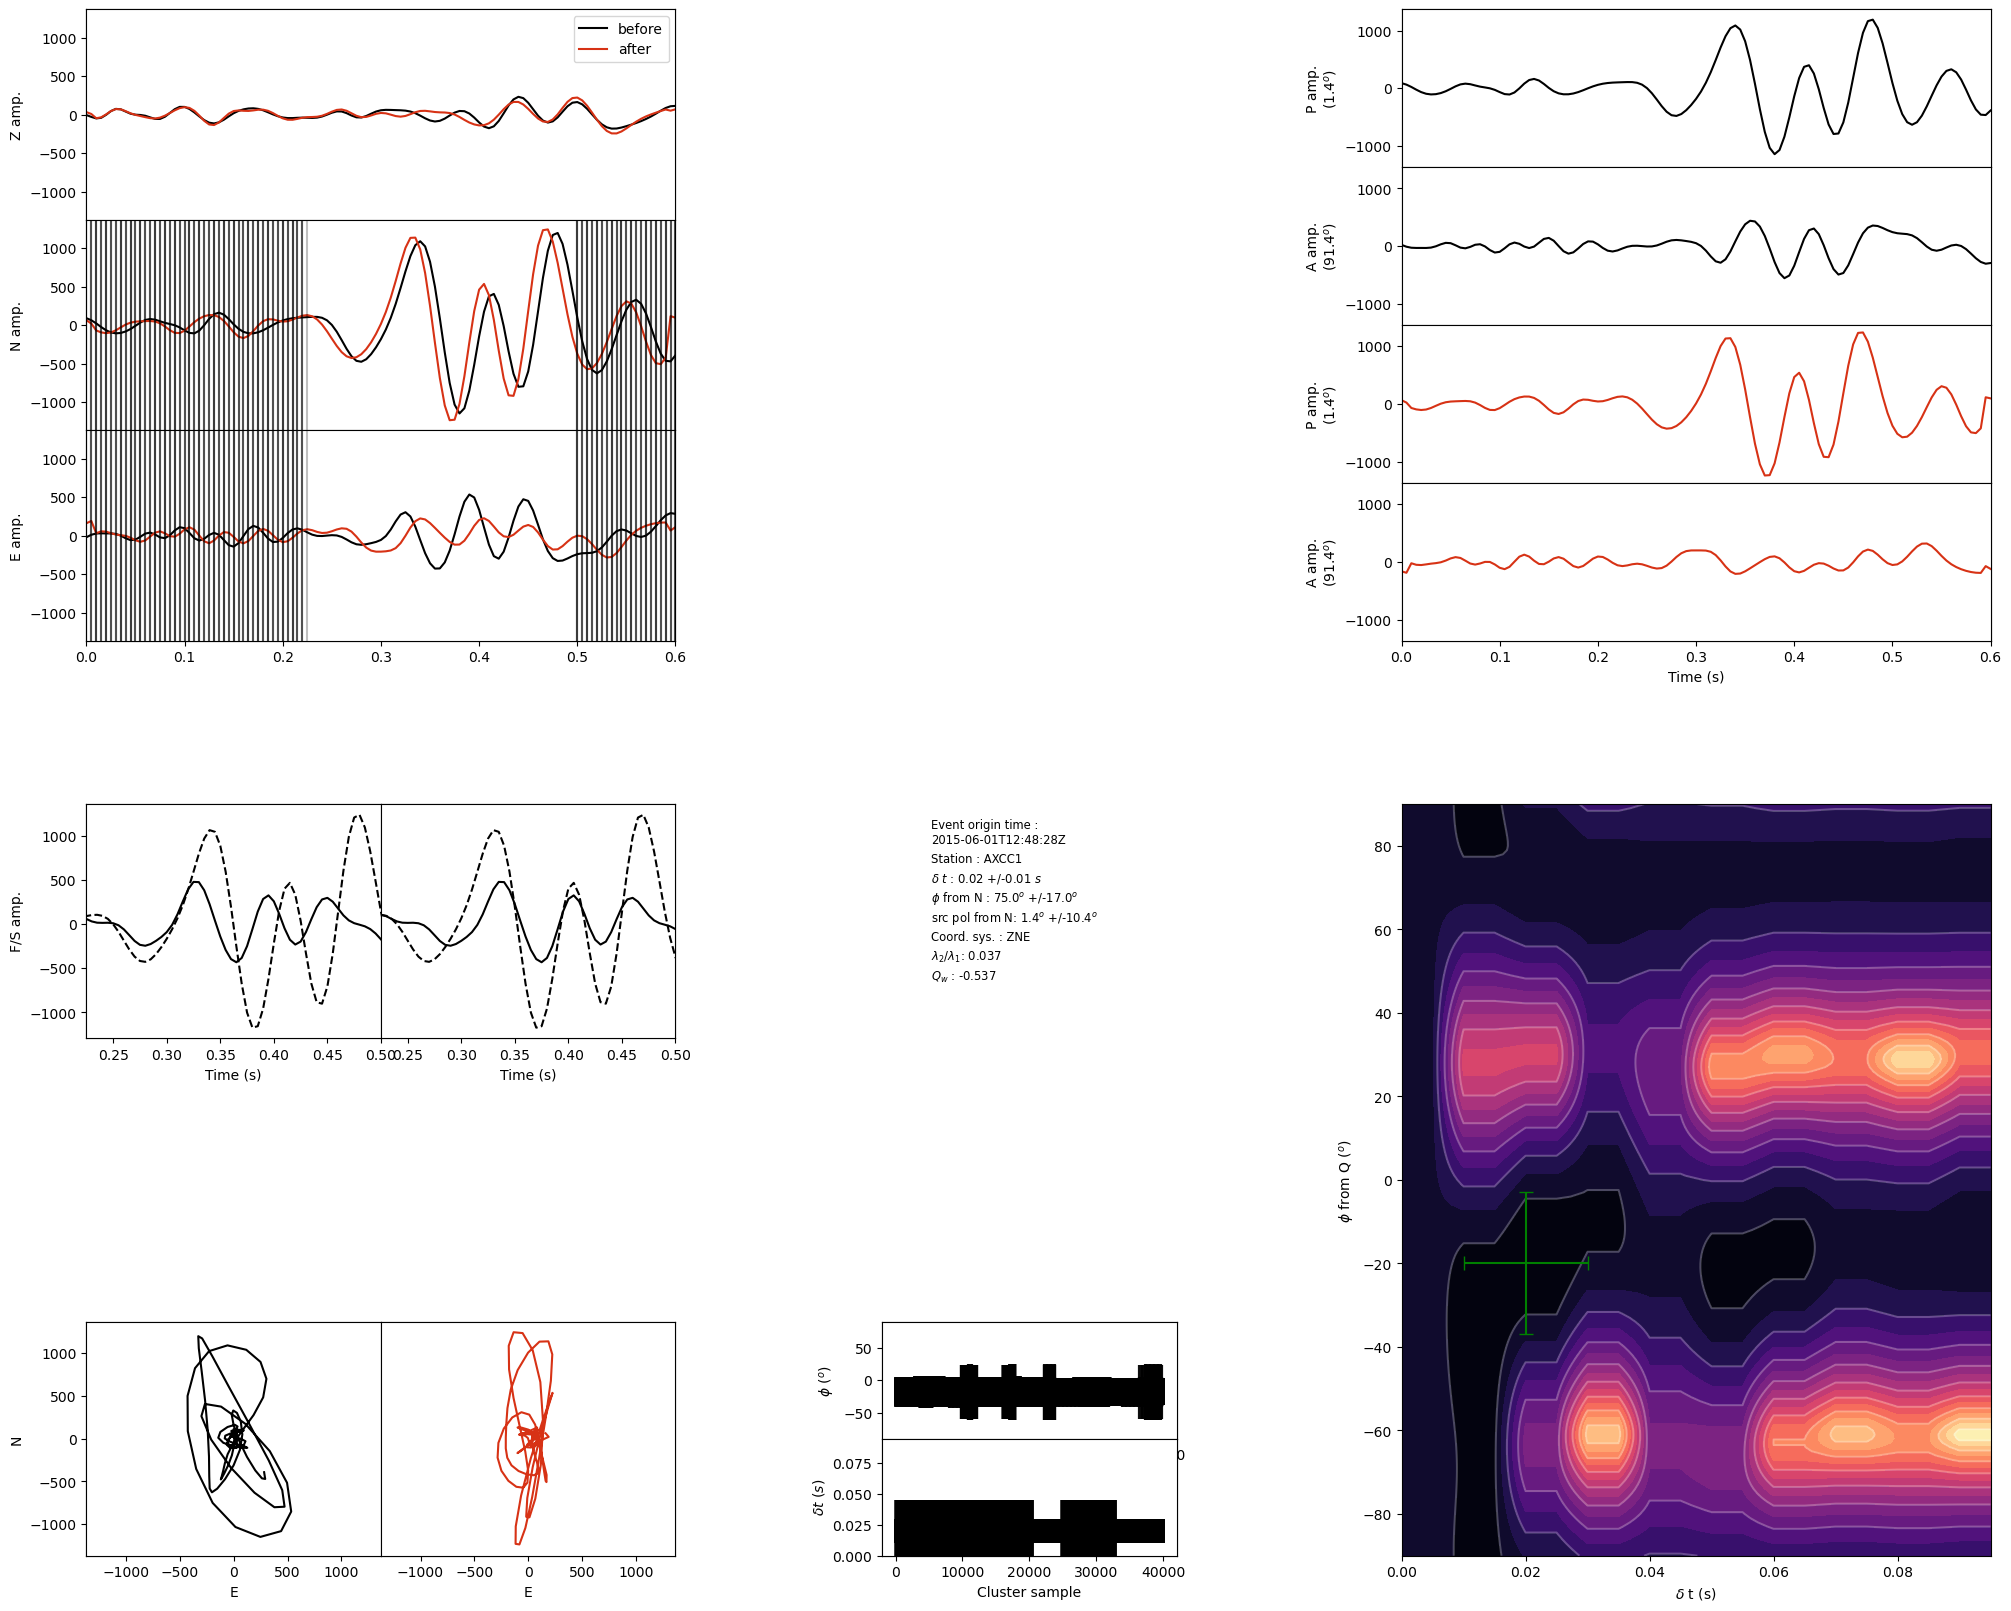

  ✓ Splitting analysis complete!
    Fast axis (φ): 75.0°
    Delay time (δt): 0.020s
  ✓ SUCCESS!
    Fast axis (φ): 75.0°
    Delay time (δt): 0.020s
    φ error: ±17.0°
    δt error: ±0.010s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 121
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 109.77°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.90
  Rectilinearity: 0.979
  Incidence: 14.0°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.

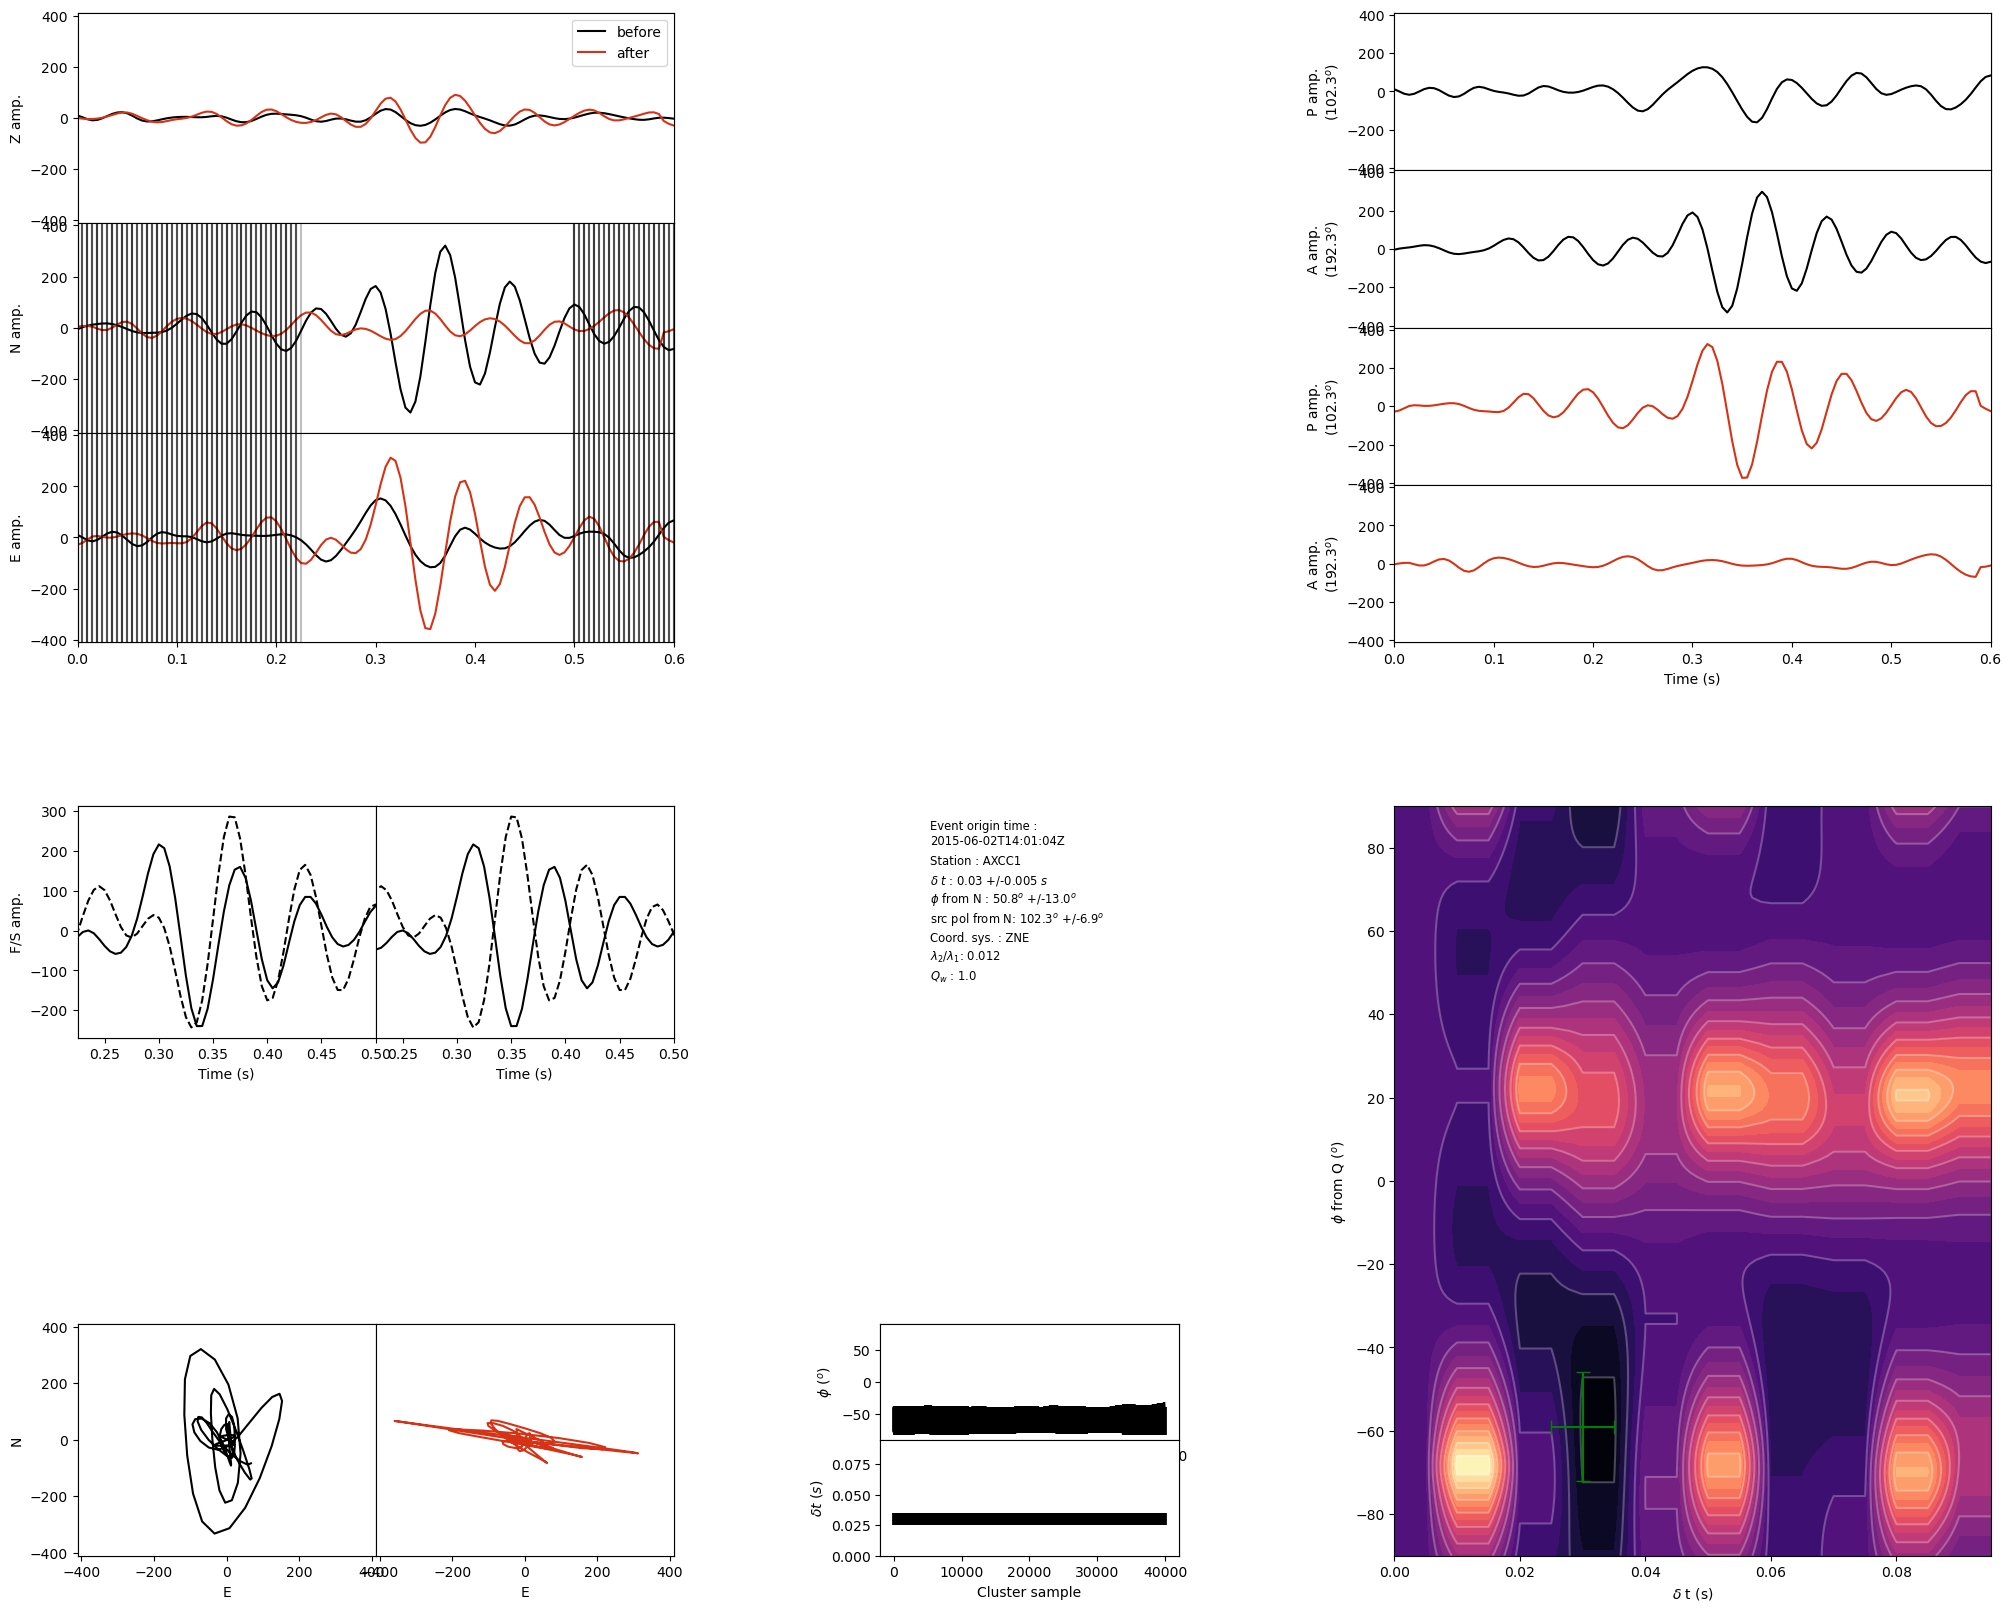

  ✓ Splitting analysis complete!
    Fast axis (φ): 50.8°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): 50.8°
    Delay time (δt): 0.030s
    φ error: ±13.0°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 147
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 109.84°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.65
  Rectilinearity: 0.995
  Incidence: 6.6°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

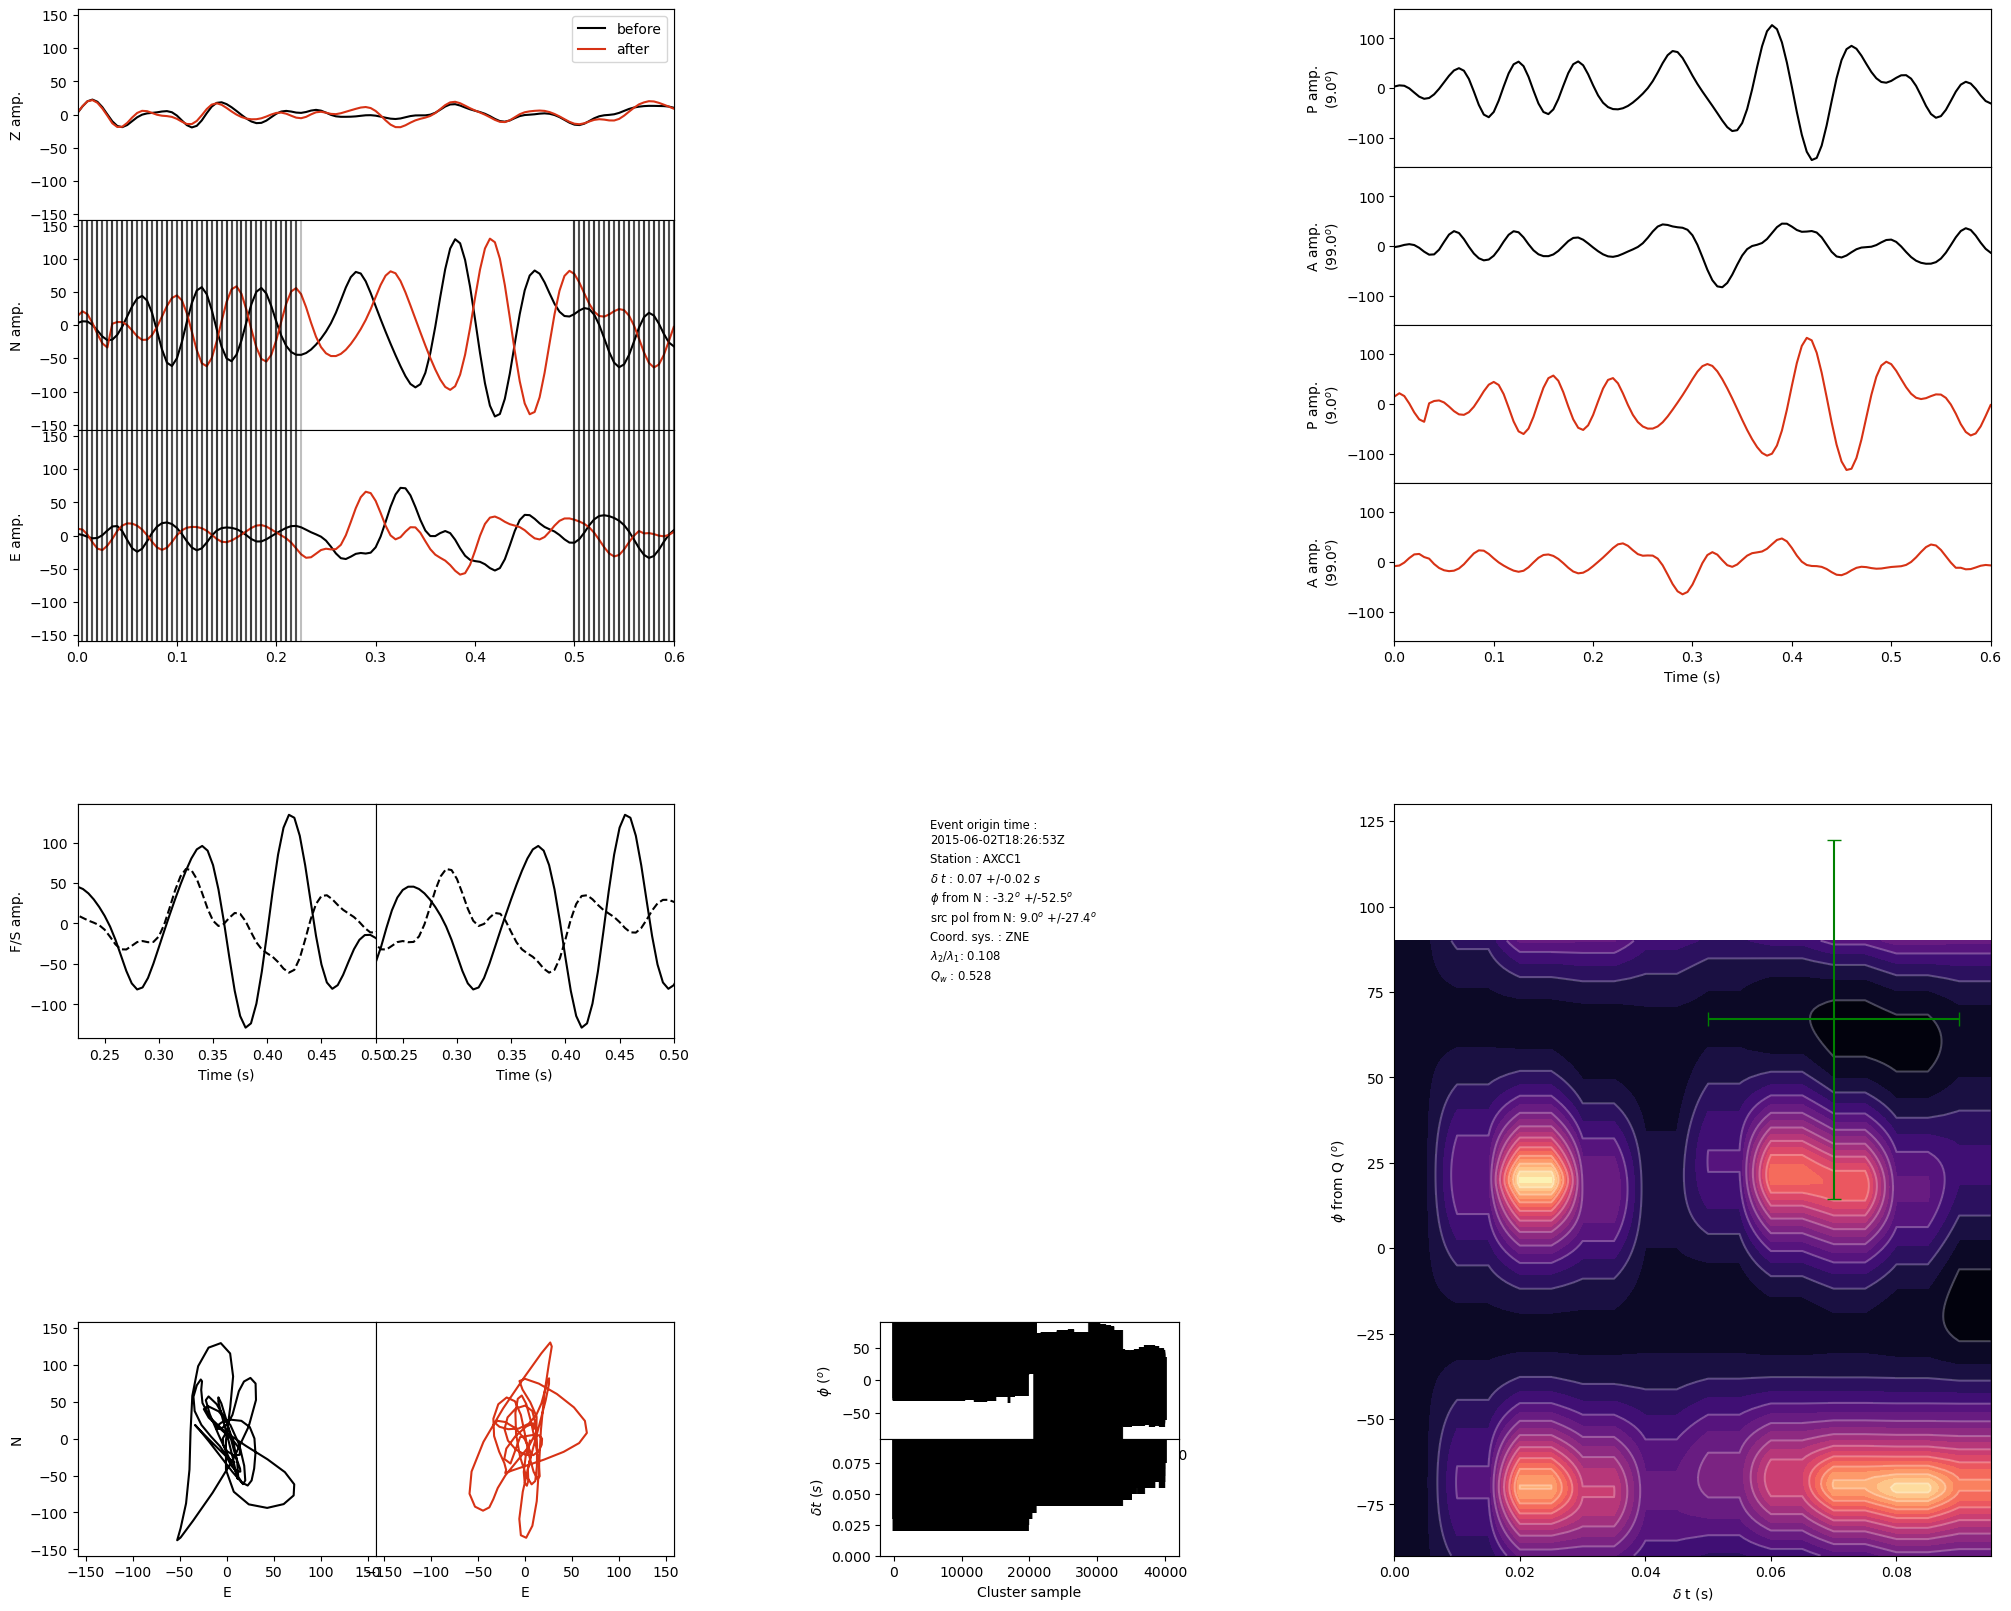

  ✓ Splitting analysis complete!
    Fast axis (φ): -3.2°
    Delay time (δt): 0.070s
  ✓ SUCCESS!
    Fast axis (φ): -3.2°
    Delay time (δt): 0.070s
    φ error: ±52.5°
    δt error: ±0.020s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 149
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 133.87°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.67
  Rectilinearity: 0.947
  Incidence: 28.3°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.

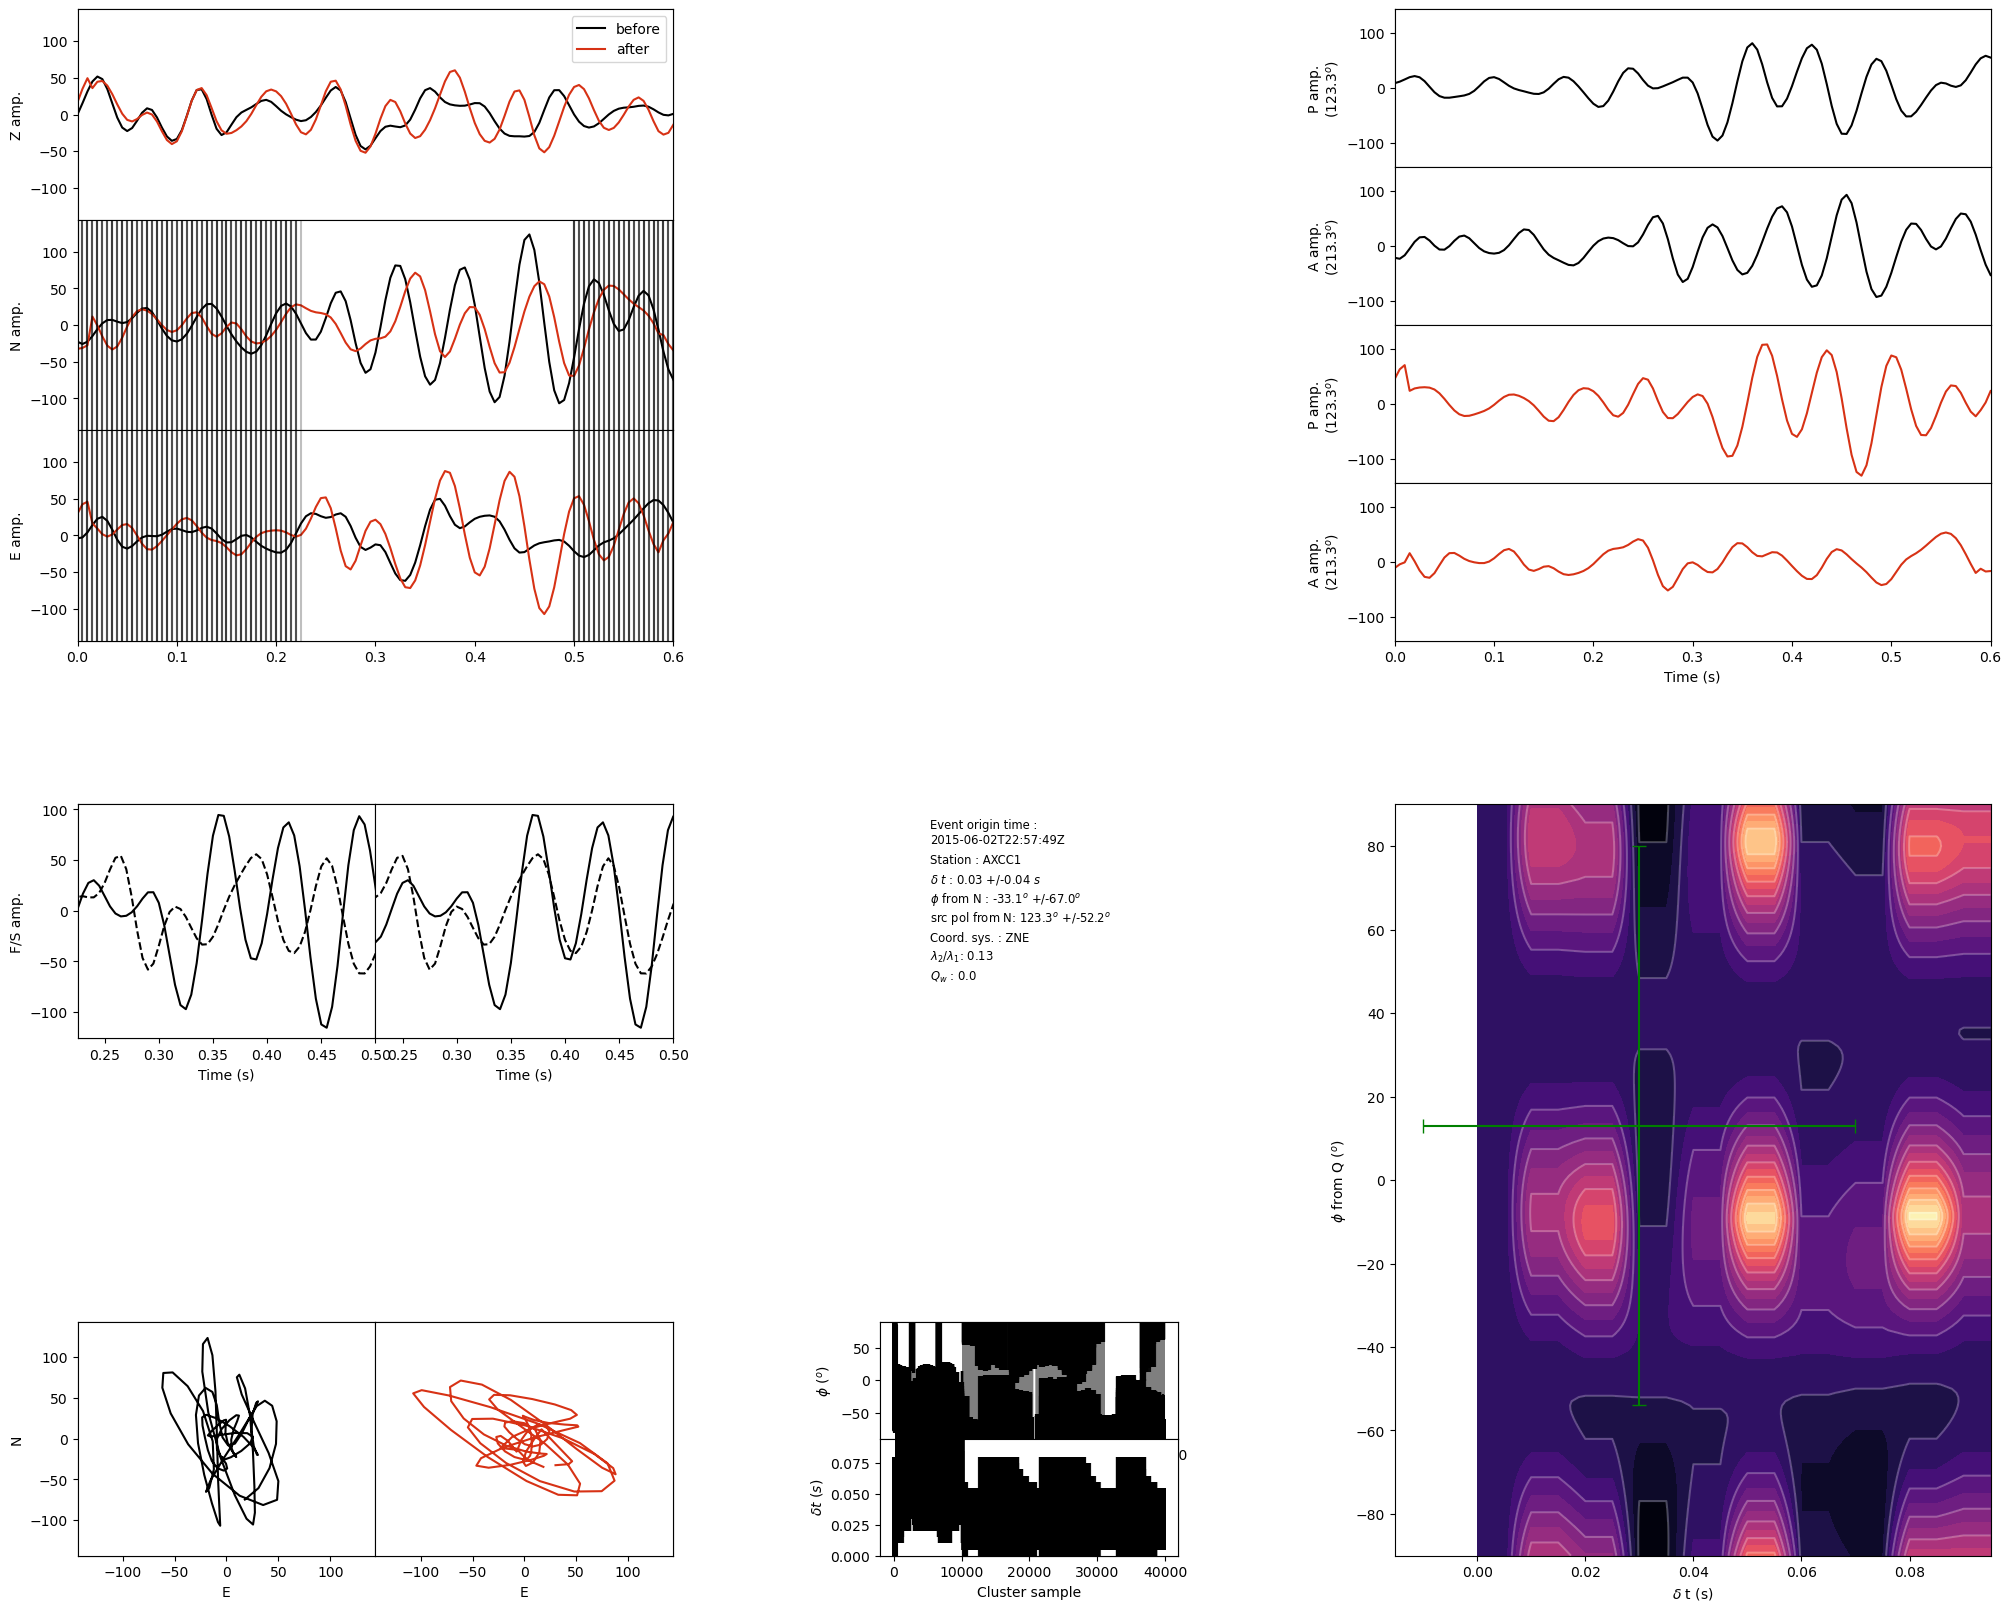

  ✓ Splitting analysis complete!
    Fast axis (φ): -33.1°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): -33.1°
    Delay time (δt): 0.030s
    φ error: ±67.0°
    δt error: ±0.040s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 163
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 302.47°
  Station: AXEC2
  Magnitude: 0.0
  SNR: 2.96
  Rectilinearity: 0.980
  Incidence: 28.5°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-2

  ✓ Splitting analysis complete!
    Fast axis (φ): 7.5°
    Delay time (δt): 0.060s
  ✓ SUCCESS!
    Fast axis (φ): 7.5°
    Delay time (δt): 0.060s
    φ error: ±33.0°
    δt error: ±0.015s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 173
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 35.80°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.83
  Rectilinearity: 0.865
  Incidence: 21.1°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 H

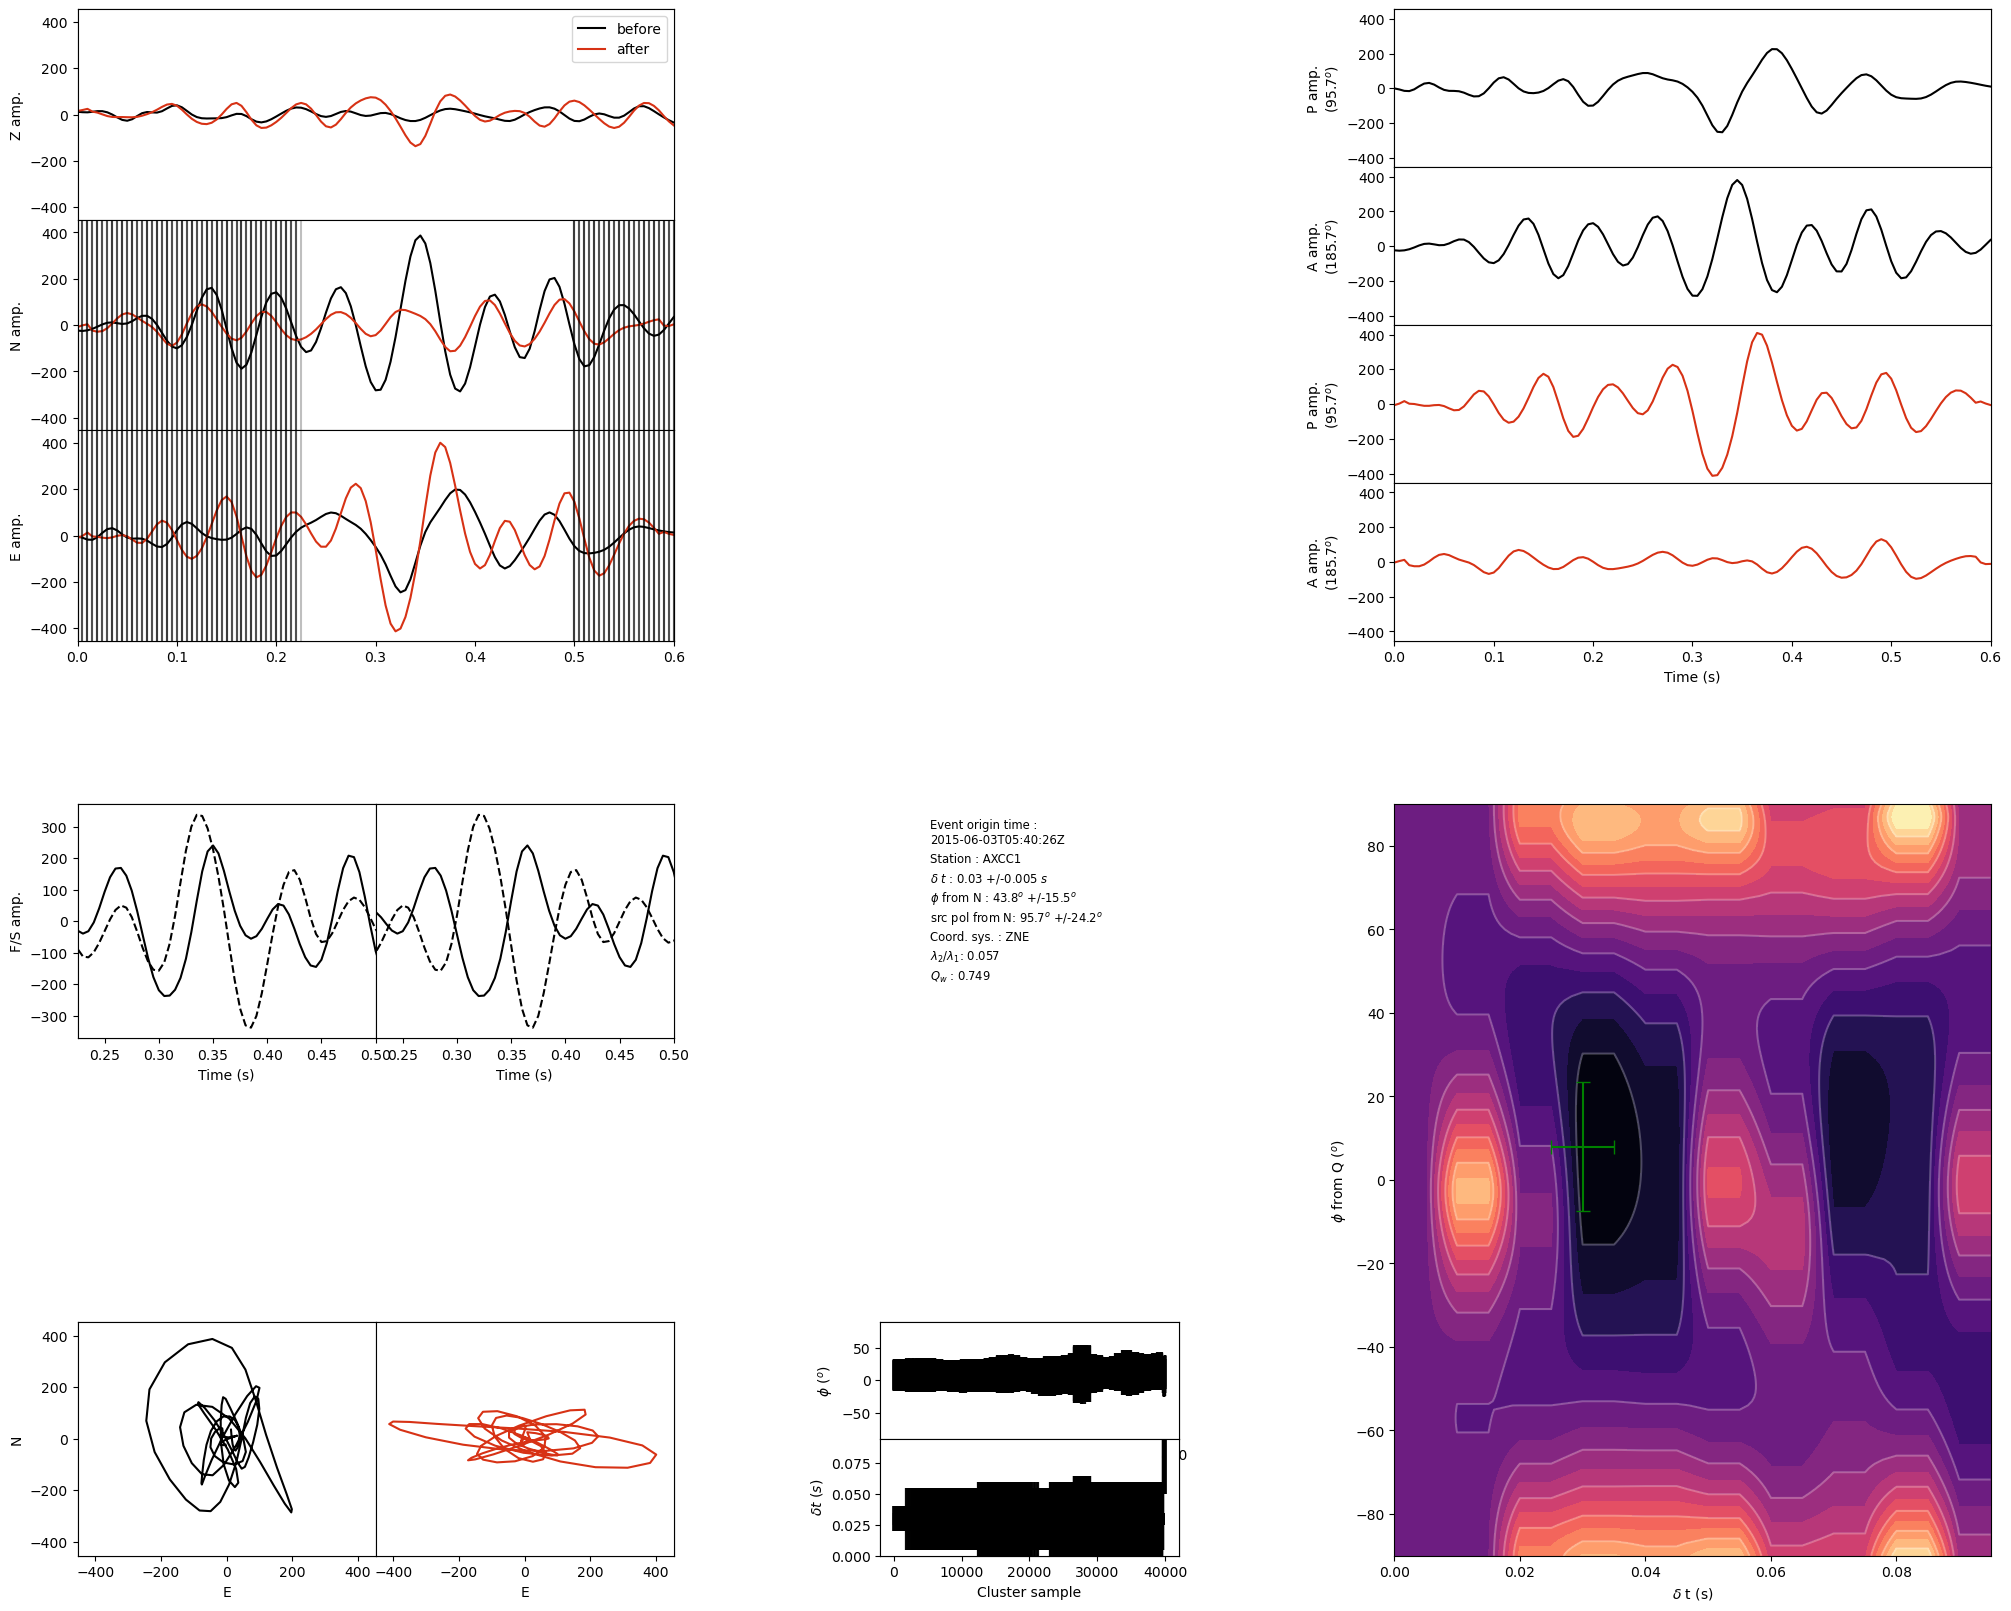

  ✓ Splitting analysis complete!
    Fast axis (φ): 43.8°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): 43.8°
    Delay time (δt): 0.030s
    φ error: ±15.5°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 205
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 49.87°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.77
  Rectilinearity: 0.796
  Incidence: 27.6°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

  ✓ Splitting analysis complete!
    Fast axis (φ): -72.1°
    Delay time (δt): 0.050s
  ✓ SUCCESS!
    Fast axis (φ): -72.1°
    Delay time (δt): 0.050s
    φ error: ±28.5°
    δt error: ±0.030s
    Dominant period: 0.100s

Splitting Analysis Summary
Total events processed: 10
Successful splits: 10 (100.0%)

Failure breakdown:
  Missing components: 0
  Missing back-azimuth: 0
  Splitting errors: 0

────────────────────────────────────────────────────────────
Splitting Parameter Statistics
────────────────────────────────────────────────────────────
Fast axis direction (φ):
  Mean: 16.1° ± 45.9°
  Range: -72.1° to 84.6°
  Median: 6.5°

Delay time (δt):
  Mean: 0.046 ± 0.022s
  Range: 0.020s to 0.090s
  Median: 0.040s


In [15]:
# Shear-wave splitting analysis using dynamic splitting parameters
print("Performing shear-wave splitting analysis using SWSPy...")
#results = perform_splitting_on_organized_waveforms(passing_waveforms)

results = perform_splitting_on_organized_waveforms(passing_waveforms)

## 7. Visualization and Interpretation
- This section takes our results and makes a new dataframe of phi_from_N, phi_err, dt, dt_err, and datetime for each event.
- This section also plots fast direction (in +/- 0.2 radians) over time (+/- 24 hours 22:30 UTC April 23, 2015), with a colorbar representing confidence using phi_err (a 2D histogram), and in a second plot, lag time in seconds over the same time scales, also as a 2D histogram representing confidence

In [16]:
# Create results dataframe with splitting parameters
print("Creating results dataframe from splitting analysis...")

# Initialize lists to store results
event_ids = []
datetimes = []
phi_values = []
phi_errors = []
dt_values = []
dt_errors = []

# Extract results from the splitting analysis
for event_id, result_data in results.items():
    if 'result' in result_data and result_data['result'] is not None:
        result = result_data['result']
        
        # Get datetime from passing_waveforms
        if event_id in passing_waveforms:
            datetime_str = passing_waveforms[event_id]['datetime']
            
            event_ids.append(event_id)
            datetimes.append(datetime_str)
            phi_values.append(result.get('phi', np.nan))
            phi_errors.append(result.get('phi_error', np.nan))
            dt_values.append(result.get('dt', np.nan))
            dt_errors.append(result.get('dt_error', np.nan))

# Create dataframe
results_df = pd.DataFrame({
    'event_id': event_ids,
    'datetime': datetimes,
    'phi_from_N': phi_values,
    'phi_error': phi_errors,
    'dt': dt_values,
    'dt_error': dt_errors
})

# Convert datetime strings to datetime objects
results_df['datetime'] = pd.to_datetime(results_df['datetime'])

print(f"Created results dataframe with {len(results_df)} measurements")
print("\nSample results:")
display(results_df.head())

Creating results dataframe from splitting analysis...
Created results dataframe with 10 measurements

Sample results:


event_id                         datetime  phi_from_N  phi_error    dt  \
0        22 2015-06-01 05:08:11.970000+00:00   84.562724       17.0  0.06   
1        41 2015-06-01 11:11:00.740000+00:00    2.110829       20.5  0.02   
2        45 2015-06-01 12:03:08.570000+00:00    5.632551       14.5  0.09   
3        52 2015-06-01 12:48:32.860000+00:00   74.976188       17.0  0.02   
4       121 2015-06-02 14:01:08.410000+00:00   50.772814       13.0  0.03   

   dt_error  
0     0.035  
1     0.010  
2     0.005  
3     0.010  
4     0.005

In [17]:
# Show sample results
sample_event = list(results.keys())[0]
sample_result = results[sample_event]['result']  # Access the 'result' key
print(f"\nSample results for event {sample_event}:")
print(f"  {sample_result['station']}: φ={sample_result['phi']:.1f}°, δt={sample_result['dt']:.3f}s")


Sample results for event 22:
  AXCC1: φ=84.6°, δt=0.060s


## 8. Results Analysis and Visualization

This section analyzes the splitting results, creates summary statistics, and generates visualizations of the splitting parameters.

In [18]:
# Results analysis and visualization

# Process results directly from the results dictionary
results_compiled_df = compile_results_dataframe(results, extended_catalog)
	
print(f"Compiled {len(results_compiled_df)} splitting measurements")

# Create visualizations
create_splitting_plots(results_compiled_df)

# Save results
results_output_path = '../results/splitting_tomography_results.csv'
results_compiled_df.to_csv(results_output_path, index=False)
print(f"\nResults saved to: {results_output_path}")

# Display sample of results
print("\nSample of compiled results:")
display(results_compiled_df.head())

Compiled 10 splitting measurements



SPLITTING ANALYSIS SUMMARY
Total measurements: 10
Unique stations: 3
Unique events: 10

Fast Axis Direction (φ):
  Mean: 16.1° ± 48.4°
  Range: -72.1° to 84.6°

Delay Time (δt):
  Mean: 0.046 ± 0.024 seconds
  Range: 0.020 to 0.090 seconds

Quality Metrics:
  Average SNR: 3.1
  Magnitude range: 0.0 to 0.0

Results saved to: ../results/splitting_tomography_results.csv

Sample of compiled results:


event_id station        phi    dt  phi_error  dt_error   avg_snr  \
0        22   AXCC1  84.562724  0.06       17.0     0.035  3.783436   
1        41   AXCC1   2.110829  0.02       20.5     0.010  3.017074   
2        45   AXAS1   5.632551  0.09       14.5     0.005  2.376653   
3        52   AXCC1  74.976188  0.02       17.0     0.010  4.941380   
4       121   AXCC1  50.772814  0.03       13.0     0.005  2.895081   

   magnitude  event_lat  event_lon  event_depth  window_duration  quality  \
0        0.0    45.9487  -129.9862         1.11              0.5  unknown   
1        0.0    45.9173  -129.9840         0.01              0.5  unknown   
2        0.0    45.9435  -129.9823         1.34              0.5  unknown   
3        0.0    45.9540  -129.9915         1.38              0.5  unknown   
4        0.0    45.9515  -129.9940         0.84              0.5  unknown   

   back_azimuth  rectilinearity  incidence  
0    112.562724        0.967455  21.990016  
1    156.110829        0.799946  22.781181  
2     70.632551        0.928851  18.112676  
3     94.976188        0.981996  11.783334  
4    109.772814        0.979005  14.009647

## 9. Load Velocity Model and Initialize Ray Tracer

In [19]:
# Create velocity model
vm = AxialVelocityModel(
    nx=101, ny=101, nz=51,
    x_range=(-16.0, 16.0),
    y_range=(-16.0, 16.0),
    z_range=(0.0, 10.0)
)

# Build velocity model with geological features
velocity = vm.create_model(
    v0_seafloor=2.0,
    velocity_gradient=0.3,
    caldera_center=(0.0, 0.0),
    caldera_width=3.0,
    caldera_length=8.0,
    caldera_angle=15.0,
    magma_chamber_depth=(1.1, 2.3),
    mmr_east_offset=0.7
)

print(f"✓ Velocity model created")
print(f"  Grid: {vm.nx} × {vm.ny} × {vm.nz}")
print(f"  Velocity range: {velocity.min():.2f} - {velocity.max():.2f} km/s")

# Create initial anisotropic model
velocity_fast, velocity_slow, phi_fast, percent_anisotropy = vm.create_anisotropic_model(
    base_percent_anisotropy=4.0,
    phi_base=37.0,
    vary_with_structure=True,
    caldera_center=(0.0, 0.0),
    mmr_east_offset=0.7,
    caldera_width=3.0,
    caldera_length=8.0,
    caldera_angle=15.0
)

print(f"\n✓ Initial anisotropic model created")
print(f"  Percent anisotropy: {percent_anisotropy.min():.1f} - {percent_anisotropy.max():.1f}%")
print(f"  Fast direction range: {phi_fast.min():.1f}° - {phi_fast.max():.1f}°")

# Initialize ray tracer
ray_tracer = RayTracer(vm)
print(f"\n✓ Ray tracer initialized")

✓ Velocity model created
  Grid: 101 × 101 × 51
  Velocity range: -0.00 - 5.00 km/s

✓ Initial anisotropic model created
  Percent anisotropy: 1.2 - 6.5%
  Fast direction range: 0.3° - 179.7°

✓ Ray tracer initialized

✓ Initial anisotropic model created
  Percent anisotropy: 1.2 - 6.5%
  Fast direction range: 0.3° - 179.7°

✓ Ray tracer initialized


## 10. Ray Tracing Through Anisotropic Model

Use the RayTracer class to:
1. Compute ray paths for each event-station pair
2. Calculate fast and slow ray paths through anisotropic medium
3. Predict splitting parameters from velocity structure
4. Compare predictions with measurements

In [31]:
obs_array = OBSArray()
station_df = obs_array.get_station_dataframe()
AXIAL_LAT, AXIAL_LON = 45.9540, -130.0088

In [32]:
# Compute predicted splitting from ray tracing
print("Computing ray paths and predicted splitting...")

ray_predictions = []

for idx, row in results_compiled_df.iterrows():
    # Convert event location to Cartesian relative coordinates
    # (catalog uses geographic, need to convert to model coordinates)
    event_x = (row['event_lon'] - AXIAL_LON) * 111.0 * np.cos(np.radians(row['event_lat']))
    event_y = (row['event_lat'] - AXIAL_LAT) * 111.0
    event_z = row['event_depth']
    
    # Get station Cartesian coordinates
    station_info = station_df[station_df['station'] == row['station']]
    if len(station_info) == 0:
        continue
    
    station_info = station_info.iloc[0]
    station_x = station_info['x_km']
    station_y = station_info['y_km']
    station_z = abs(station_info['z_km'])  # Make positive for depth
    
    # Check if locations are within velocity model bounds
    #if not (vm.x_min <= event_x <= vm.x_max and 
    #        vm.y_min <= event_y <= vm.y_max and
    #        vm.z_min <= event_z <= vm.z_max):
    #    continue
    
    #if not (vm.x_min <= station_x <= vm.x_max and 
    #        vm.y_min <= station_y <= vm.y_max):
    #    continue
    
    try:
        # Compute anisotropic ray paths
        ray_fast, ray_slow, path_stats = ray_tracer.compute_anisotropic_ray_paths(
            source_loc=[event_x, event_y, event_z],
            receiver_loc=[station_x, station_y, station_z],
            npts=50
        )
        
        # Extract predicted splitting parameters from path statistics
        predicted_dt = path_stats['predicted_dt']
        
        # Get average fast direction along ray path
        # Sample anisotropy parameters along the ray
        phi_along_ray = []
        for i in range(len(ray_fast)):
            x, y, z = ray_fast[i]
            # Find nearest grid point
            ix = int((x - vm.x_min) / (vm.x_max - vm.x_min) * (vm.nx - 1))
            iy = int((y - vm.y_min) / (vm.y_max - vm.y_min) * (vm.ny - 1))
            iz = int((z - vm.z_min) / (vm.z_max - vm.z_min) * (vm.nz - 1))
            
            # Clamp indices
            ix = max(0, min(ix, vm.nx - 1))
            iy = max(0, min(iy, vm.ny - 1))
            iz = max(0, min(iz, vm.nz - 1))
            
            phi_along_ray.append(phi_fast[ix, iy, iz])
        
        predicted_phi = np.mean(phi_along_ray)
        
        ray_predictions.append({
            'idx': idx,
            'event_id': row['event_id'],
            'station': row['station'],
            'predicted_phi': predicted_phi,
            'predicted_dt': predicted_dt,
            'ray_length_fast': path_stats['travel_time_fast'],
            'ray_length_slow': path_stats['travel_time_slow'],
            'max_ray_separation': path_stats['max_separation'],
            'mean_ray_separation': path_stats['mean_separation']
        })
        
    except Exception as e:
        if idx % 10 == 0:
            print(f"  Warning: Ray tracing failed for pair {idx}: {e}")
        continue
    
    if idx % 10 == 0:
        print(f"  Processed {idx+1}/{len(results_df)} pairs")

ray_predictions_df = pd.DataFrame(ray_predictions)
print(f"\n✓ Computed ray predictions for {len(ray_predictions_df)} pairs")

ray_predictions_df['predicted_dt'] = ray_predictions_df['predicted_dt']

if len(ray_predictions_df) > 0:
    print(f"\nPredicted splitting statistics:")
    print(f"  Fast direction: {ray_predictions_df['predicted_phi'].mean():.1f}° ± {ray_predictions_df['predicted_phi'].std():.1f}°")
    print(f"  Delay time: {ray_predictions_df['predicted_dt'].mean():.3f} ± {ray_predictions_df['predicted_dt'].std():.3f} s")
    print(f"  Ray separation: {ray_predictions_df['max_ray_separation'].mean():.3f} km (max)")
    
    # Merge with results
    results_with_predictions = results_compiled_df.merge(ray_predictions_df, on=['event_id', 'station'], how='left')

Computing ray paths and predicted splitting...
  Processed 1/10 pairs
  Processed 1/10 pairs

✓ Computed ray predictions for 10 pairs

Predicted splitting statistics:
  Fast direction: 62.8° ± 20.9°
  Delay time: 0.058 ± 0.043 s
  Ray separation: 0.038 km (max)

✓ Computed ray predictions for 10 pairs

Predicted splitting statistics:
  Fast direction: 62.8° ± 20.9°
  Delay time: 0.058 ± 0.043 s
  Ray separation: 0.038 km (max)


## 11. Direct Inversion from Splitting Measurements

Use a single forward model to create a data-driven anisotropy model:
1. Trace rays through the initial model for each event-station pair
2. Determine which grid cells each ray passes through
3. Accumulate observed splitting measurements by grid cell
4. Compute cell-wise averages weighted by measurement uncertainty
5. Update anisotropy model with data-derived values
6. Visualize initial vs. data-derived models

In [33]:
# ============================================================================
# STEP 1: Extract initial model parameters from velocity model
# ============================================================================
print("\n" + "="*80)
print("STEP 1: Extracting initial model parameters")
print("="*80)

# Get initial anisotropy parameters from velocity model
initial_percent_anisotropy = vm.percent_anisotropy.copy()  # Make copies to preserve original
initial_phi_fast = vm.phi_fast.copy()

print(f"Initial model statistics:")
print(f"  Percent anisotropy: {initial_percent_anisotropy.mean():.2f}% (mean), range: {initial_percent_anisotropy.min():.2f} - {initial_percent_anisotropy.max():.2f}%")
print(f"  Fast direction: {initial_phi_fast.mean():.1f}° (mean), range: {initial_phi_fast.min():.1f}° - {initial_phi_fast.max():.1f}°")


STEP 1: Extracting initial model parameters
Initial model statistics:
  Percent anisotropy: 2.84% (mean), range: 1.20 - 6.50%
  Fast direction: 39.0° (mean), range: 0.3° - 179.7°


In [34]:
# ============================================================================
# STEP 2: Prepare observed splitting measurements from results
# ============================================================================
print("\n" + "="*80)
print("STEP 2: Preparing observed splitting measurements")
print("="*80)

# Filter out NaN values and ensure we have valid predictions
valid_results = results_with_predictions.dropna(subset=['phi', 'dt', 'predicted_phi', 'predicted_dt']).copy()


# Extract arrays from valid results
observed_phi = valid_results['phi'].values          # Fast directions (degrees)
observed_dt = valid_results['dt'].values            # Delay times (seconds)
observed_phi_error = valid_results['phi_error'].values
observed_dt_error = valid_results['dt_error'].values

# Convert event locations to model coordinates
event_locations = []
for _, row in valid_results.iterrows():
    event_x = (row['event_lon'] - AXIAL_LON) * 111.0 * np.cos(np.radians(row['event_lat']))
    event_y = (row['event_lat'] - AXIAL_LAT) * 111.0
    event_z = row['event_depth']
    event_locations.append([event_x, event_y, event_z])

event_locations = np.array(event_locations)

# Get station locations from station_df
station_locations = []
for _, row in valid_results.iterrows():
    station_info = station_df[station_df['station'] == row['station']].iloc[0]
    station_x = station_info['x_km']
    station_y = station_info['y_km']
    station_z = abs(station_info['z_km'])
    station_locations.append([station_x, station_y, station_z])

station_locations = np.array(station_locations)

print(f"Prepared {len(observed_phi)} splitting measurements for optimization")
print(f"  φ range: {np.nanmin(observed_phi):.1f}° - {np.nanmax(observed_phi):.1f}°")
print(f"  δt range: {np.nanmin(observed_dt):.4f} - {np.nanmax(observed_dt):.4f} s")
print(f"  Event locations range:")
print(f"    X: {event_locations[:, 0].min():.2f} to {event_locations[:, 0].max():.2f} km")
print(f"    Y: {event_locations[:, 1].min():.2f} to {event_locations[:, 1].max():.2f} km")
print(f"    Z: {event_locations[:, 2].min():.2f} to {event_locations[:, 2].max():.2f} km")


STEP 2: Preparing observed splitting measurements
Prepared 10 splitting measurements for optimization
  φ range: -72.1° - 84.6°
  δt range: 0.0200 - 0.0900 s
  Event locations range:
    X: 0.89 to 2.05 km
    Y: -4.07 to 1.59 km
    Z: 0.01 to 2.32 km


In [26]:
# ============================================================================
# STEP 3: Initialize optimizer with initial model
# ============================================================================
print("\n" + "="*80)
print("STEP 3: Initializing optimizer")
print("="*80)

optimizer = AnisotropyOptimizer(
    velocity_model = vm,
    ray_tracer = ray_tracer,
    coarse_grid_shape=(101, 101, 51),  # Downsampled from 101×101×51
    regularization_lambda=0.1,       # Tikhonov regularization strength
    max_iterations=10,                # Maximum optimization iterations
    convergence_tol=1e-3,             # Convergence criterion
)

print(f"✓ Optimizer initialized")
print(f"  Coarse grid: {optimizer.coarse_shape} = {np.prod(optimizer.coarse_shape):,} parameters")
print(f"  Regularization λ: {optimizer.reg_lambda}")
print(f"  Max iterations: {optimizer.max_iter}")

# Setup model with initial anisotropy and fast directions from velocity model
print("\nSetting up model in optimizer with initial parameters...")
optimizer.setup_model(
    percent_anisotropy_init=initial_percent_anisotropy,
    phi_fast_init=initial_phi_fast
)

print(f"✓ Model setup complete with initial anisotropy structure")


STEP 3: Initializing optimizer
✓ AnisotropyOptimizer initialized
  Fine grid: (101, 101, 51)
  Coarse grid: (101, 101, 51)
  Downsampling factors: (1, 1, 1)
  Number of parameters: 1040502
✓ Optimizer initialized
  Coarse grid: (101, 101, 51) = 520,251 parameters
  Regularization λ: 0.1
  Max iterations: 10

Setting up model in optimizer with initial parameters...

✓ Model initialized
  Percent anisotropy range: 1.20 - 6.50%
  Phi fast range: 0.3° - 179.7°
✓ Model setup complete with initial anisotropy structure


In [37]:
# ============================================================================
# STEP 4: Direct Inversion from Splitting Data
# ============================================================================
print("\n" + "="*80)
print("STEP 4: Direct inversion from splitting measurements")
print("="*80)
print("This will trace rays and directly assign splitting to grid cells...")

# Initialize accumulation grids
nx, ny, nz = vm.nx, vm.ny, vm.nz
phi_sum = np.zeros((nx, ny, nz))
phi_weight_sum = np.zeros((nx, ny, nz))
dt_sum = np.zeros((nx, ny, nz))
dt_weight_sum = np.zeros((nx, ny, nz))
ray_count = np.zeros((nx, ny, nz))

# Get average velocity for dt->anisotropy conversion
v_avg = vm.velocity.mean()

failed_rays = 0

# Process each observation
for i in range(len(observed_phi)):
    event_loc = event_locations[i]
    station_loc = station_locations[i]
    
    try:
        # Trace rays through initial model
        ray_fast, ray_slow, path_stats = ray_tracer.compute_anisotropic_ray_paths(
            event_loc, station_loc, npts=100
        )
        
        # Use average of fast and slow ray paths
        ray_path = (ray_fast + ray_slow) / 2.0
        
        # Determine which grid cells this ray passes through
        for point in ray_path:
            # Convert to grid indices
            ix = int((point[0] - vm.x_min) / (vm.x_max - vm.x_min) * (nx - 1))
            iy = int((point[1] - vm.y_min) / (vm.y_max - vm.y_min) * (ny - 1))
            iz = int((point[2] - vm.z_min) / (vm.z_max - vm.z_min) * (nz - 1))
            
            # Clamp to valid range
            ix = max(0, min(ix, nx - 1))
            iy = max(0, min(iy, ny - 1))
            iz = max(0, min(iz, nz - 1))
            
            # Compute weights (inverse variance)
            phi_weight = 1.0 / max(observed_phi_error[i]**2, 1.0)
            dt_weight = 1.0 / max(observed_dt_error[i]**2, 0.0001)
            
            # Accumulate weighted values
            phi_sum[ix, iy, iz] += observed_phi[i] * phi_weight
            phi_weight_sum[ix, iy, iz] += phi_weight
            dt_sum[ix, iy, iz] += observed_dt[i] * dt_weight
            dt_weight_sum[ix, iy, iz] += dt_weight
            ray_count[ix, iy, iz] += 1
            
    except Exception as e:
        failed_rays += 1
        if failed_rays <= 5:
            print(f"  Warning: Ray tracing failed for observation {i}: {e}")
        continue
    
    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{len(observed_phi)} observations...")

print(f"\n✓ Ray tracing complete")
print(f"  Successful: {len(observed_phi) - failed_rays}/{len(observed_phi)}")
print(f"  Failed: {failed_rays}")

# Compute weighted averages for cells with data
data_derived_phi = initial_phi_fast.copy()
data_derived_percent_aniso = initial_percent_anisotropy.copy()

# Cells with ray coverage
has_data = phi_weight_sum > 0

# Compute averages
data_derived_phi[has_data] = phi_sum[has_data] / phi_weight_sum[has_data]
avg_dt = np.zeros_like(dt_sum)
avg_dt[has_data] = dt_sum[has_data] / dt_weight_sum[has_data]

# Convert delay time to percent anisotropy
# Typical cell size
cell_dx = (vm.x_max - vm.x_min) / nx
cell_dy = (vm.y_max - vm.y_min) / ny
cell_dz = (vm.z_max - vm.z_min) / nz
cell_length = np.sqrt(cell_dx**2 + cell_dy**2 + cell_dz**2)

# percent_aniso ≈ (dt × v_avg / cell_length) × 200
data_derived_percent_aniso[has_data] = (avg_dt[has_data] * v_avg / cell_length) * 200

# Clamp to reasonable range
data_derived_percent_aniso = np.clip(data_derived_percent_aniso, 0, 10)

print(f"\n✓ Direct inversion complete")
print(f"  Cells with data: {np.sum(has_data):,} / {nx*ny*nz:,} ({100*np.sum(has_data)/(nx*ny*nz):.1f}%)")
print(f"  Data-derived φ: {data_derived_phi[has_data].mean():.1f}° ± {data_derived_phi[has_data].std():.1f}°")
print(f"  Data-derived anisotropy: {data_derived_percent_aniso[has_data].mean():.2f}% ± {data_derived_percent_aniso[has_data].std():.2f}%")


STEP 4: Direct inversion from splitting measurements
This will trace rays and directly assign splitting to grid cells...
  Processed 10/10 observations...

✓ Ray tracing complete
  Successful: 10/10
  Failed: 0

✓ Direct inversion complete
  Cells with data: 129 / 520,251 (0.0%)
  Data-derived φ: 15.8° ± 39.9°
  Data-derived anisotropy: 10.00% ± 0.00%
  Processed 10/10 observations...

✓ Ray tracing complete
  Successful: 10/10
  Failed: 0

✓ Direct inversion complete
  Cells with data: 129 / 520,251 (0.0%)
  Data-derived φ: 15.8° ± 39.9°
  Data-derived anisotropy: 10.00% ± 0.00%


In [40]:
# ============================================================================
# STEP 5: Update velocity model with data-derived parameters
# ============================================================================
print("\n" + "="*80)
print("STEP 5: Updating velocity model with data-derived parameters")
print("="*80)

# Update the velocity model attributes with data-derived values
vm.percent_anisotropy = data_derived_percent_aniso
vm.phi_fast = data_derived_phi

# Recalculate fast and slow velocities using updated anisotropy
vm.velocity_fast = vm.velocity * (1.0 + vm.percent_anisotropy / 200.0)
vm.velocity_slow = vm.velocity * (1.0 - vm.percent_anisotropy / 200.0)

print(f"✓ Velocity model updated with data-derived anisotropy")
print(f"  Fast velocity range: {vm.velocity_fast.min():.2f} - {vm.velocity_fast.max():.2f} km/s")
print(f"  Slow velocity range: {vm.velocity_slow.min():.2f} - {vm.velocity_slow.max():.2f} km/s")

# Calculate change statistics
delta_anisotropy = data_derived_percent_aniso - initial_percent_anisotropy
delta_phi = data_derived_phi - initial_phi_fast

# Handle phi wraparound for differences
delta_phi = np.where(delta_phi > 90, delta_phi - 180, delta_phi)
delta_phi = np.where(delta_phi < -90, delta_phi + 180, delta_phi)

print(f"\n✓ Model update statistics:")
print(f"  Anisotropy change: {delta_anisotropy[has_data].mean():.2f}% ± {delta_anisotropy[has_data].std():.2f}%")
print(f"  Fast direction change: {delta_phi[has_data].mean():.1f}° ± {delta_phi[has_data].std():.1f}°")

# Save direct inversion results
print("\nSaving direct inversion results...")
direct_inversion_results = {
    'initial_anisotropy': initial_percent_anisotropy,
    'initial_phi': initial_phi_fast,
    'data_derived_anisotropy': data_derived_percent_aniso,
    'data_derived_phi': data_derived_phi,
    'delta_anisotropy': delta_anisotropy,
    'delta_phi': delta_phi,
    'has_data_mask': has_data,
    'ray_count': ray_count,
    'phi_weight_sum': phi_weight_sum,
    'dt_weight_sum': dt_weight_sum
}

np.savez('../results/direct_inversion_results.npz', **direct_inversion_results)
print("✓ Saved: ../results/direct_inversion_results.npz")

print("\n" + "="*80)
print("DIRECT INVERSION COMPLETE")
print("="*80)


STEP 5: Updating velocity model with data-derived parameters
✓ Velocity model updated with data-derived anisotropy
  Fast velocity range: -0.00 - 5.07 km/s
  Slow velocity range: -0.00 - 4.93 km/s

✓ Model update statistics:
  Anisotropy change: 6.34% ± 1.41%
  Fast direction change: -11.5° ± 50.4°

Saving direct inversion results...
✓ Saved: ../results/direct_inversion_results.npz

DIRECT INVERSION COMPLETE


## 11. Visualization and Summary

Create visualizations of:
1. Velocity model and anisotropy structure
2. Ray paths (fast vs slow)
3. Splitting measurements distribution
4. Optimization convergence (when available)

FileNotFoundError: [Errno 2] No such file or directory: '../figures/direct_inversion_results.png'

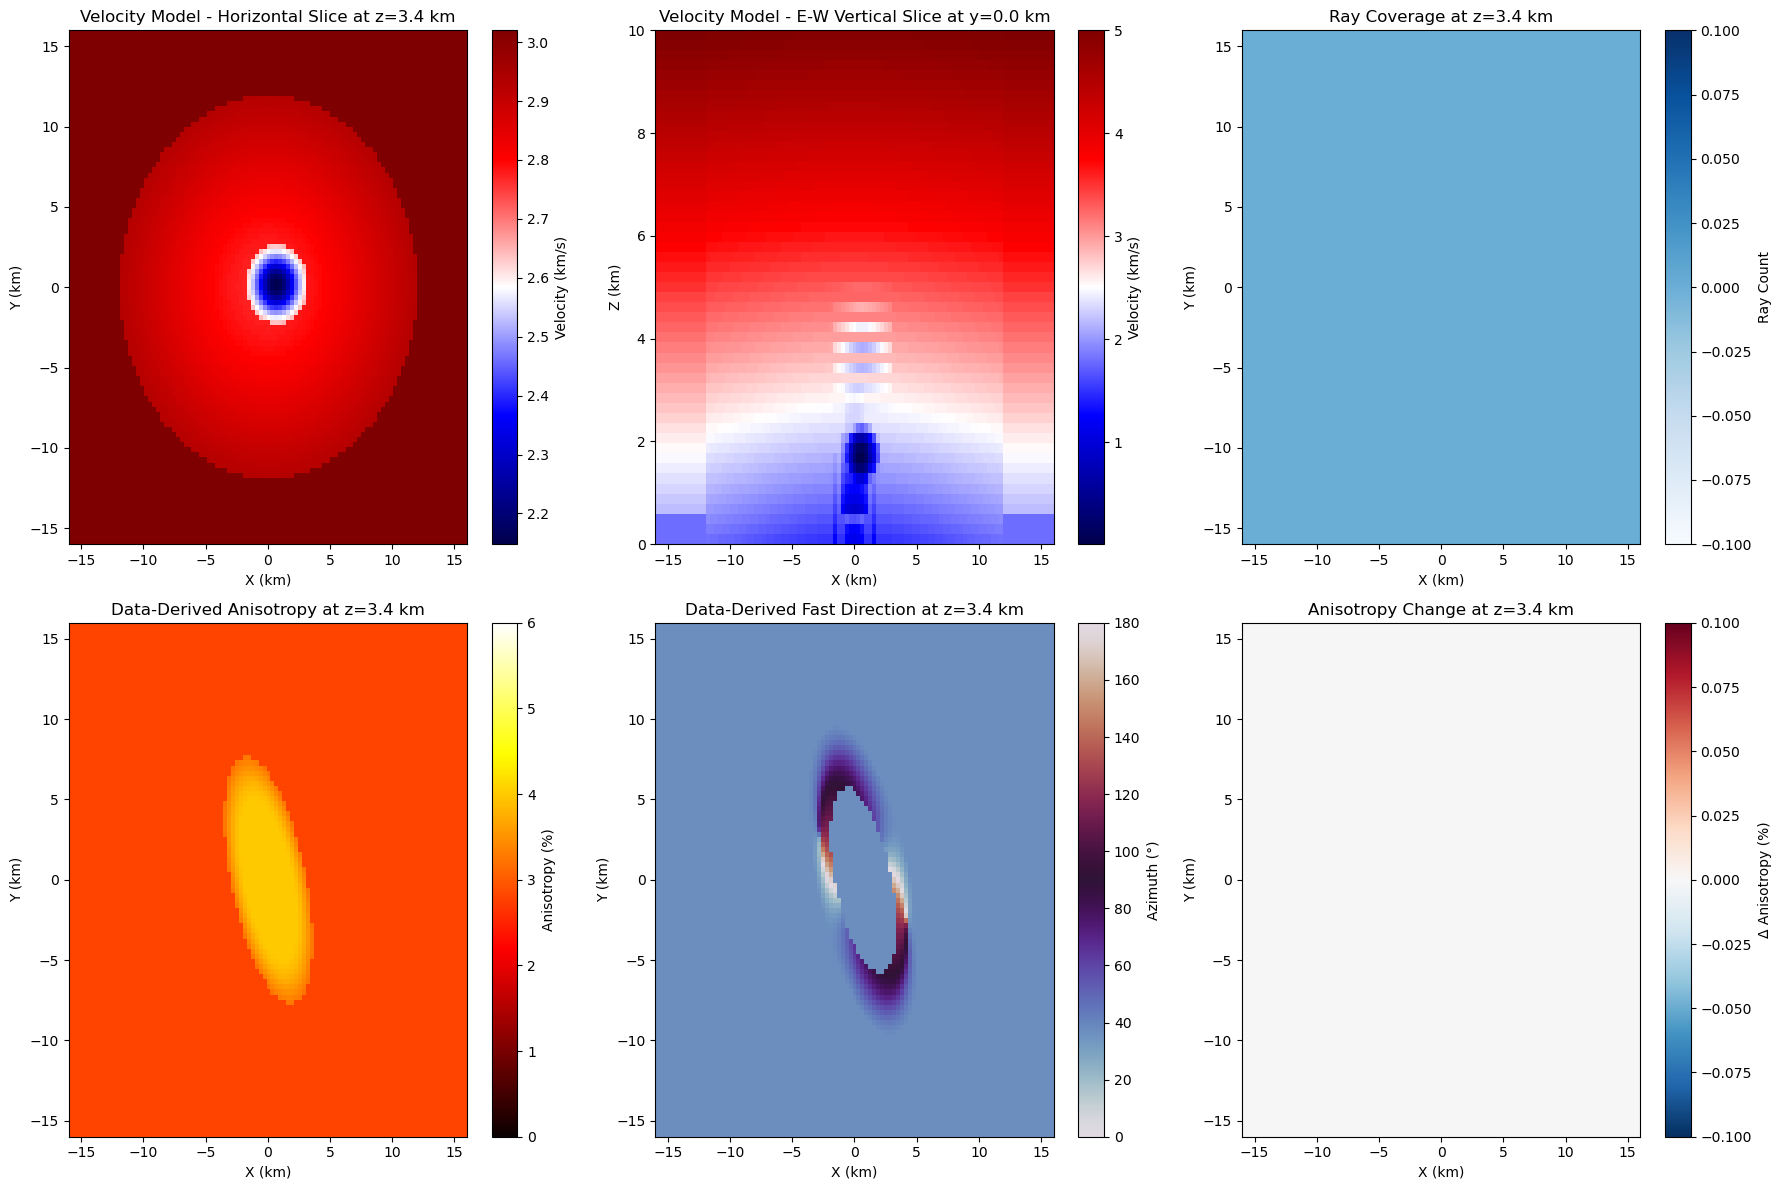

In [44]:
# Plot velocity model with anisotropy - Updated for direct inversion results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Horizontal slice through velocity model
z_slice_idx = vm.nz // 3
vel_slice = vm.velocity[:, :, z_slice_idx].T
im = axes[0, 0].imshow(vel_slice, origin='lower', cmap='seismic', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max])
axes[0, 0].set_xlabel('X (km)')
axes[0, 0].set_ylabel('Y (km)')
axes[0, 0].set_title(f'Velocity Model - Horizontal Slice at z={vm.z[z_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[0, 0], label='Velocity (km/s)')

# Vertical slice (E-W)
y_slice_idx = vm.ny // 2
vel_slice_vert = vm.velocity[:, y_slice_idx, :].T
im = axes[0, 1].imshow(vel_slice_vert, origin='lower', cmap='seismic', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.z_min, vm.z_max])
axes[0, 1].set_xlabel('X (km)')
axes[0, 1].set_ylabel('Z (km)')
axes[0, 1].set_title(f'Velocity Model - E-W Vertical Slice at y={vm.y[y_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[0, 1], label='Velocity (km/s)')

# Ray coverage map
im = axes[0, 2].imshow(ray_count[:, :, z_slice_idx].T, 
                       origin='lower', cmap='Blues', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max])
axes[0, 2].set_xlabel('X (km)')
axes[0, 2].set_ylabel('Y (km)')
axes[0, 2].set_title(f'Ray Coverage at z={vm.z[z_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[0, 2], label='Ray Count')

# Data-derived anisotropy percentage
im = axes[1, 0].imshow(data_derived_percent_aniso[:, :, z_slice_idx].T, 
                       origin='lower', cmap='hot', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                       vmin=0, vmax=6)
axes[1, 0].set_xlabel('X (km)')
axes[1, 0].set_ylabel('Y (km)')
axes[1, 0].set_title(f'Data-Derived Anisotropy at z={vm.z[z_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[1, 0], label='Anisotropy (%)')

# Data-derived fast direction
im = axes[1, 1].imshow(data_derived_phi[:, :, z_slice_idx].T,
                       origin='lower', cmap='twilight', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                       vmin=0, vmax=180)
axes[1, 1].set_xlabel('X (km)')
axes[1, 1].set_ylabel('Y (km)')
axes[1, 1].set_title(f'Data-Derived Fast Direction at z={vm.z[z_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[1, 1], label='Azimuth (°)')

# Change in anisotropy (data - initial)
delta_plot = delta_anisotropy[:, :, z_slice_idx].T
vmax_delta = max(abs(np.nanmin(delta_plot)), abs(np.nanmax(delta_plot)))
im = axes[1, 2].imshow(delta_plot,
                       origin='lower', cmap='RdBu_r', aspect='auto',
                       extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                       vmin=-vmax_delta, vmax=vmax_delta)
axes[1, 2].set_xlabel('X (km)')
axes[1, 2].set_ylabel('Y (km)')
axes[1, 2].set_title(f'Anisotropy Change at z={vm.z[z_slice_idx]:.1f} km')
plt.colorbar(im, ax=axes[1, 2], label='Δ Anisotropy (%)')

plt.tight_layout()
plt.savefig('../figures/direct_inversion_results.png', dpi=150, bbox_inches='tight')
print("✓ Saved: ../figures/direct_inversion_results.png")
plt.show()

# Plot example ray paths with updated predictions
if len(ray_predictions_df) > 0:
    # Select a few example pairs
    n_examples = min(3, len(ray_predictions_df))
    example_indices = ray_predictions_df.sample(n=n_examples)['idx'].values
    
    fig = plt.figure(figsize=(15, 5))
    
    for plot_idx, data_idx in enumerate(example_indices):
        ax = fig.add_subplot(1, n_examples, plot_idx + 1, projection='3d')
        
        row = results_with_predictions.iloc[data_idx]
        
        # Convert coordinates
        event_x = (row['event_lon'] - AXIAL_LON) * 111.0 * np.cos(np.radians(row['event_lat']))
        event_y = (row['event_lat'] - AXIAL_LAT) * 111.0
        event_z = row['event_depth']
        
        station_info = station_df[station_df['station'] == row['station']].iloc[0]
        station_x = station_info['x_km']
        station_y = station_info['y_km']
        station_z = abs(station_info['z_km'])
        
        # Compute rays through updated model
        try:
            ray_fast, ray_slow, path_stats = ray_tracer.compute_anisotropic_ray_paths(
                [event_x, event_y, event_z],
                [station_x, station_y, station_z],
                npts=50
            )
            
            # Plot rays
            ax.plot(ray_fast[:, 0], ray_fast[:, 1], ray_fast[:, 2], 
                   'r-', linewidth=2, label='Fast S-wave')
            ax.plot(ray_slow[:, 0], ray_slow[:, 1], ray_slow[:, 2],
                   'b-', linewidth=2, label='Slow S-wave')
            
            # Plot endpoints
            ax.scatter([event_x], [event_y], [event_z], 
                      c='gold', s=100, marker='*', label='Event')
            ax.scatter([station_x], [station_y], [station_z],
                      c='black', s=100, marker='^', label='Station')
            
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Y (km)')
            ax.set_zlabel('Depth (km)')
            
            # Updated predictions from data-derived model
            predicted_dt_new = path_stats['predicted_dt']
            ax.set_title(f"{row['station']}\nObs: φ={row['phi']:.0f}°, δt={row['dt']:.3f}s\nPred: δt={predicted_dt_new:.3f}s")
            ax.legend(loc='upper right', fontsize=8)
            ax.invert_zaxis()
            
        except Exception as e:
            print(f"Could not plot ray {plot_idx}: {e}")
    
    plt.tight_layout()
    plt.savefig('../figures/example_ray_paths_updated.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: ../figures/example_ray_paths_updated.png")
    plt.show()

# Create comparison plot of observed vs predicted splitting
if len(valid_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Fast direction comparison
    axes[0].scatter(valid_results['phi'], valid_results['predicted_phi'], 
                   c='red', alpha=0.7, s=50)
    axes[0].plot([-90, 90], [-90, 90], 'k--', alpha=0.5)
    axes[0].set_xlabel('Observed φ (°)')
    axes[0].set_ylabel('Predicted φ (°)')
    axes[0].set_title('Fast Direction Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Calculate correlation
    phi_corr = np.corrcoef(valid_results['phi'], valid_results['predicted_phi'])[0, 1]
    axes[0].text(0.05, 0.95, f'r = {phi_corr:.2f}', transform=axes[0].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Delay time comparison
    axes[1].scatter(valid_results['dt'], valid_results['predicted_dt'], 
                   c='blue', alpha=0.7, s=50)
    dt_max = max(valid_results['dt'].max(), valid_results['predicted_dt'].max())
    axes[1].plot([0, dt_max], [0, dt_max], 'k--', alpha=0.5)
    axes[1].set_xlabel('Observed δt (s)')
    axes[1].set_ylabel('Predicted δt (s)')
    axes[1].set_title('Delay Time Comparison')
    axes[1].grid(True, alpha=0.3)
    
    # Calculate correlation
    dt_corr = np.corrcoef(valid_results['dt'], valid_results['predicted_dt'])[0, 1]
    axes[1].text(0.05, 0.95, f'r = {dt_corr:.2f}', transform=axes[1].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../figures/splitting_comparison.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: ../figures/splitting_comparison.png")
    plt.show()

print("\n✓ Direct inversion visualization complete")